In [1]:
import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from wrapper import utils
import seaborn as sns
import sys
from model import ConfigurableModel
import logomaker
from tqdm import tqdm

from wrapper.model_interpretation import attribution_score, plot_ism_scatter, plot_score_heatmap, plot_logos, ism_analysis

In [2]:
fixed_tune_config = {'lr': 0.001, 'weight_decay': 0.1, 'cnn_first_filter': 24, 'cnn_first_kernel_size': 7, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 256, 'fc_size': 256}    
model = ConfigurableModel(input_channel=4, input_size=1001, cnn_first_filter=fixed_tune_config["cnn_first_filter"], cnn_first_kernel_size=fixed_tune_config["cnn_first_kernel_size"],
                                            cnn_other_filter=fixed_tune_config["cnn_filter"], cnn_other_kernel_size=fixed_tune_config["cnn_kernel_size"], bilstm_layer=fixed_tune_config["bilstm_layer"], bilstm_hidden_size=fixed_tune_config["bilstm_hidden_size"], fc_size=fixed_tune_config["fc_size"], output_size=2)
#fold
fold = 1
model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.pkl",
                            map_location=torch.device('cpu'))
model.load_state_dict(model_weight)
model.eval()

meta_data_test_json_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/test_meta_data_SPLIT_{fold}.json"
seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
# Load the validation results to get only the top 1000 sequences with lowest average MSE (mean of control and case error) 

valid_data = pd.read_csv(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2
valid_data.head()

# Select the top 2000 sequences with lowest average MSE
selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]

# ISM (Insilico Saturation Mutagenesis)

### Normal condition (target = 0)

In [4]:
# For 2k sequences it takes ~135 minutes to run
from tangermeme.ism import saturation_mutagenesis
X_attr_ism_normal = saturation_mutagenesis(model, seq_fasta_one_hot[list(selected_sequences),:,:], target=0)
plot_matrix_ism_normal = np.average(X_attr_ism_normal, axis=0)
df_ism_normal = pd.DataFrame(plot_matrix_ism_normal.T, columns=list("ACGU"))

NameError: name 'saturation_mutagenesis' is not defined

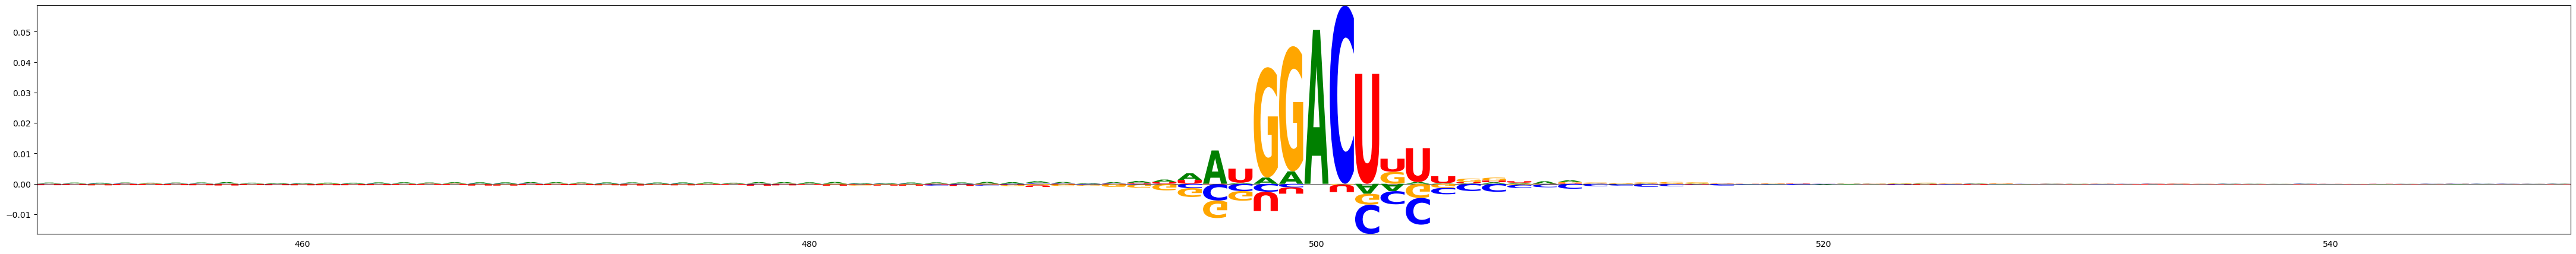

In [171]:
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo(df_ism_normal.iloc[450:550], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()

<Axes: >

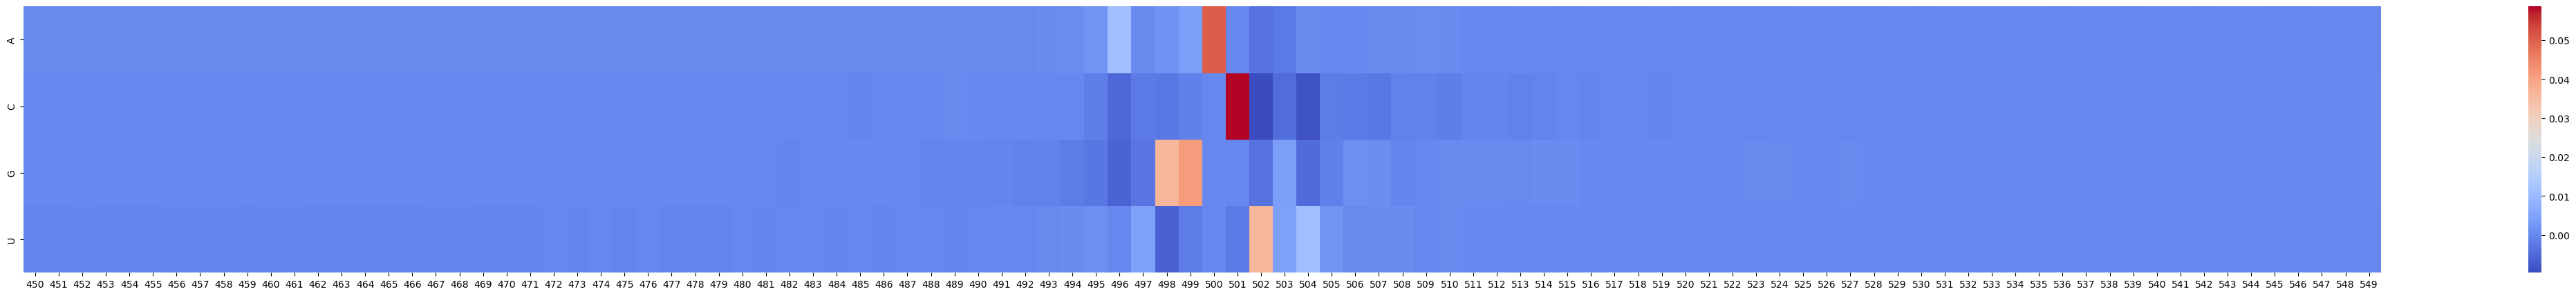

In [172]:
fig, ax = plt.subplots(figsize=(55, 5))
sns.heatmap((df_ism_normal.T).iloc[:,450:550], cmap="coolwarm")

Notes: The above plot logo and map contain the "attribution score" which not the raw delta score. The attribution socre is the delta of score subtracted with the mean score for the position. To get the raw delta you need to get the raw=True in the argument.

### Hypoxia condition (target = 1)

In [173]:
X_attr_ism_hypox = saturation_mutagenesis(model, seq_fasta_one_hot[list(selected_sequences),:,:], target=1)
plot_matrix_ism_hypox = np.average(X_attr_ism_hypox, axis=0)
df_ism_hypox = pd.DataFrame(plot_matrix_ism_hypox.T, columns=list("ACGU"))

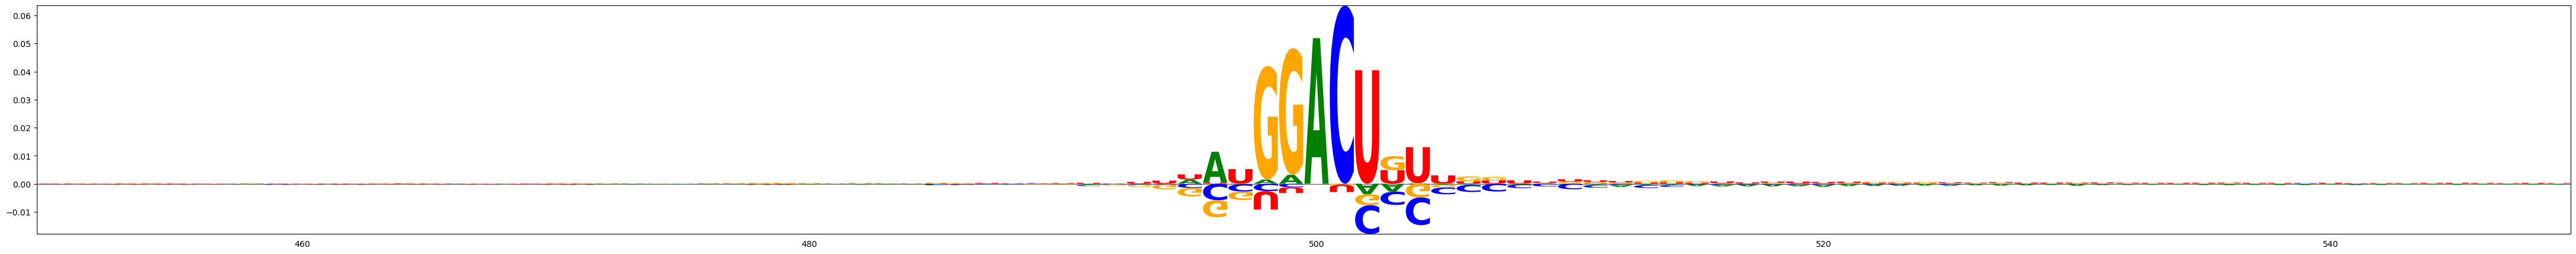

In [177]:
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo(df_ism_hypox.iloc[450:550], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()

<Axes: >

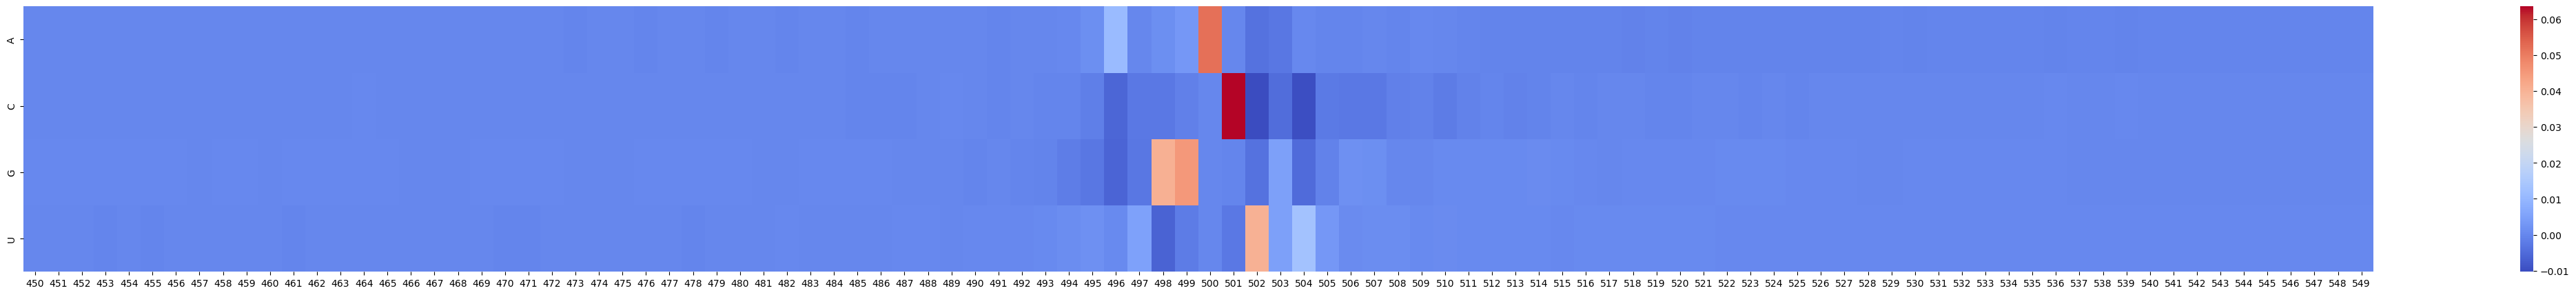

In [178]:
fig, ax = plt.subplots(figsize=(55, 5))
sns.heatmap((df_ism_hypox.T).iloc[:,450:550], cmap="coolwarm")

Notes: The above plot logo and map contain the "attribution score" which not the raw delta score. The attribution socre is the delta of score subtracted with the mean score for the position. To get the raw delta you need to get the raw=True in the argument.

## Raw results for plotting the scatter

In [181]:
y_ref, y_ism = saturation_mutagenesis(model, seq_fasta_one_hot[list(selected_sequences),:,:], raw_outputs=True)

In [245]:
def attribution_score(y0, y_hat, target):
	"""ISM attributions calculation"""

	attr = y_hat[:, :, :, target] - y0[:, None, None, target]
	attr -= torch.mean(attr, dim=1, keepdims=True)

	if len(attr.shape) > 3:
		attr = torch.mean(attr, dim=tuple(range(3, len(attr.shape))))
	return attr

In [ ]:
y_delta = y_ism - y_ref[:, None, None]
print("Saving...")
np.savez(f"ism/ism_raw_fold_{fold}_fixed_tune.npz", y_delta=y_delta, y_ism=y_ism, y_ref=y_ref)
print("Saving Done")

In [329]:
coba = np.load(f"ism/ism_raw_fold_{fold}_fixed_tune.npz")
coba["y_delta"].shape

(2000, 4, 1001, 2)

### Normal condition (target = 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


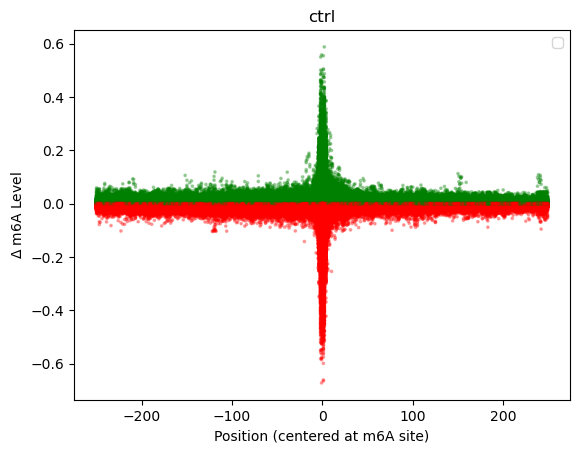

In [183]:
# Example data (replace this with your actual numpy array)
ctrl = y_delta[:,:,:,0]
ctrl = ctrl.reshape(-1,1001)
data = ctrl[:,250:750].numpy()
mutation_size = 500
# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('ctrl')
ax.legend()

# Show the plot
plt.show()

[Text(0.5, 13.249999999999995, 'Nucleotide Position Centered at m6A Site')]

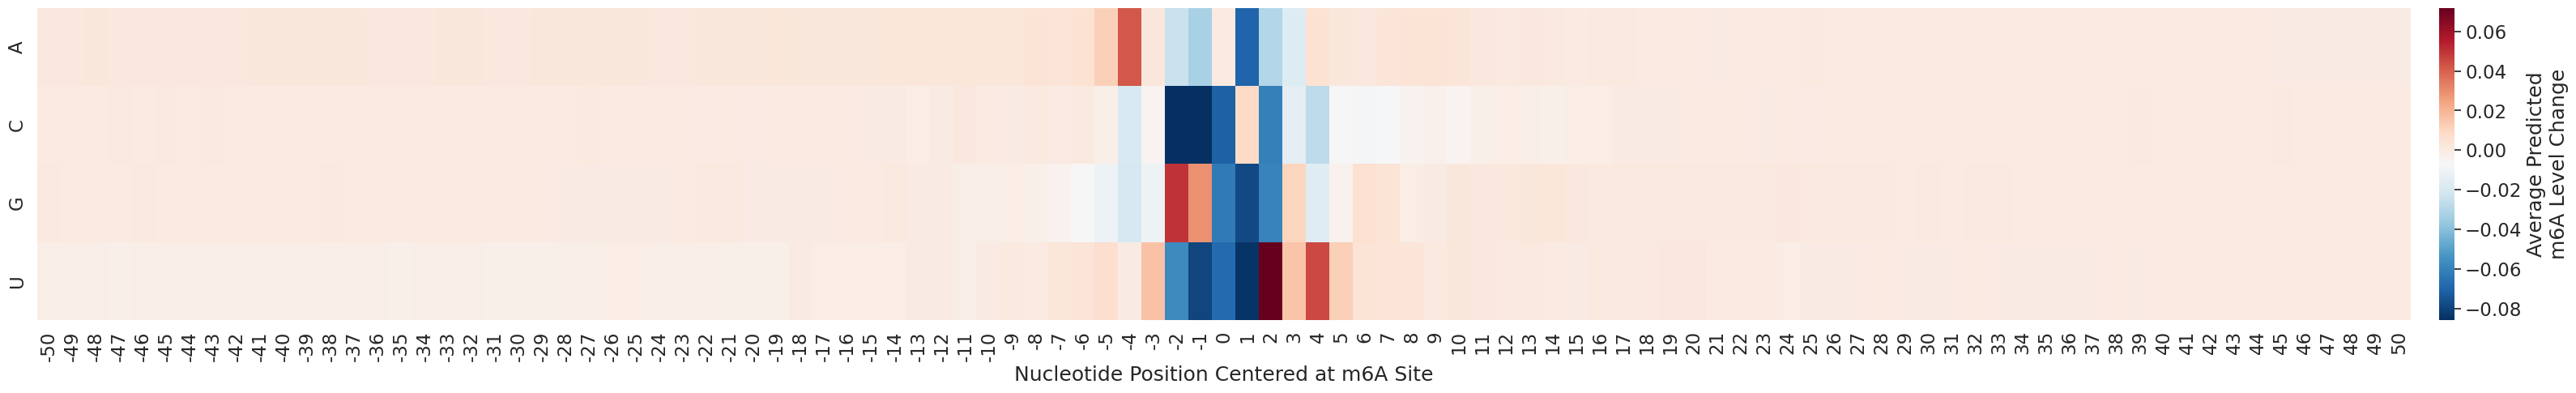

In [252]:
y_delta[:,:,:,0].shape
slice_start = 450
slice_end = 551
plot_df = pd.DataFrame(torch.mean(y_delta[:,:,:,0], dim=0).numpy().T, columns=list("ACGU"))

fig, ax = plt.subplots(figsize=(45, 5))

sns.set(font_scale=1.5, style='white')
s = sns.heatmap(data=(plot_df.T).iloc[:,slice_start:slice_end], xticklabels=list(range(slice_start-500,slice_end-500)), cmap="RdBu_r", cbar_kws={"pad": 0.01, "label":"Average Predicted\nm6A Level Change"})
s.set(xlabel='Nucleotide Position Centered at m6A Site')


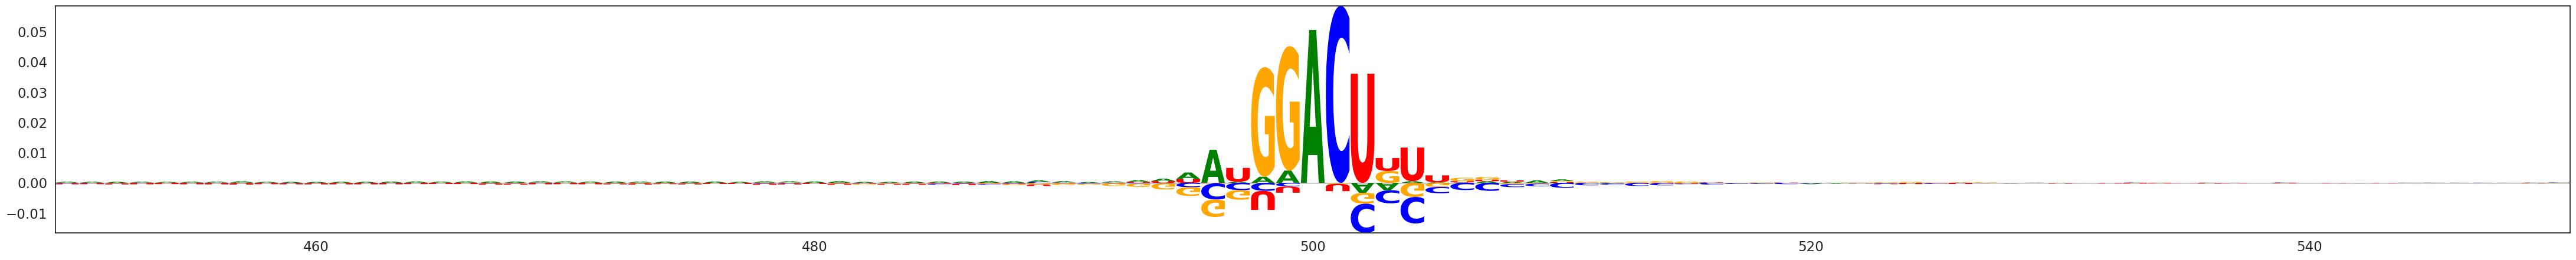

<Figure size 640x480 with 0 Axes>

In [256]:
attr = attribution_score(y_ref, y_ism, 0)
attr = attr * seq_fasta_one_hot[list(selected_sequences),:,:]
plot_logo = np.average(attr, axis=0)
plot_logo_df = pd.DataFrame(plot_logo.T, columns=list("ACGU"))
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo((plot_logo_df).iloc[slice_start:slice_end], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()
plt.savefig(f"ism/normal_logo_ism_fold_{fold}.png")


### Hypoxia condition (target=1):

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


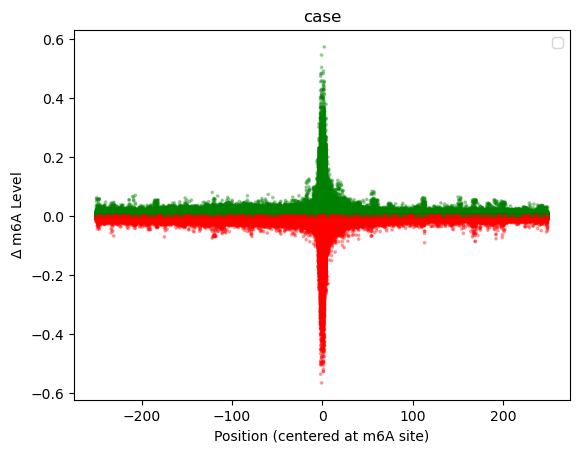

In [184]:
# Example data (replace this with your actual numpy array)
case = y_delta[:,:,:,1]
case = case.reshape(-1,1001)
data = case[:,250:750].numpy()
mutation_size = 500
# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('case')
ax.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(36, 101)
(101,)


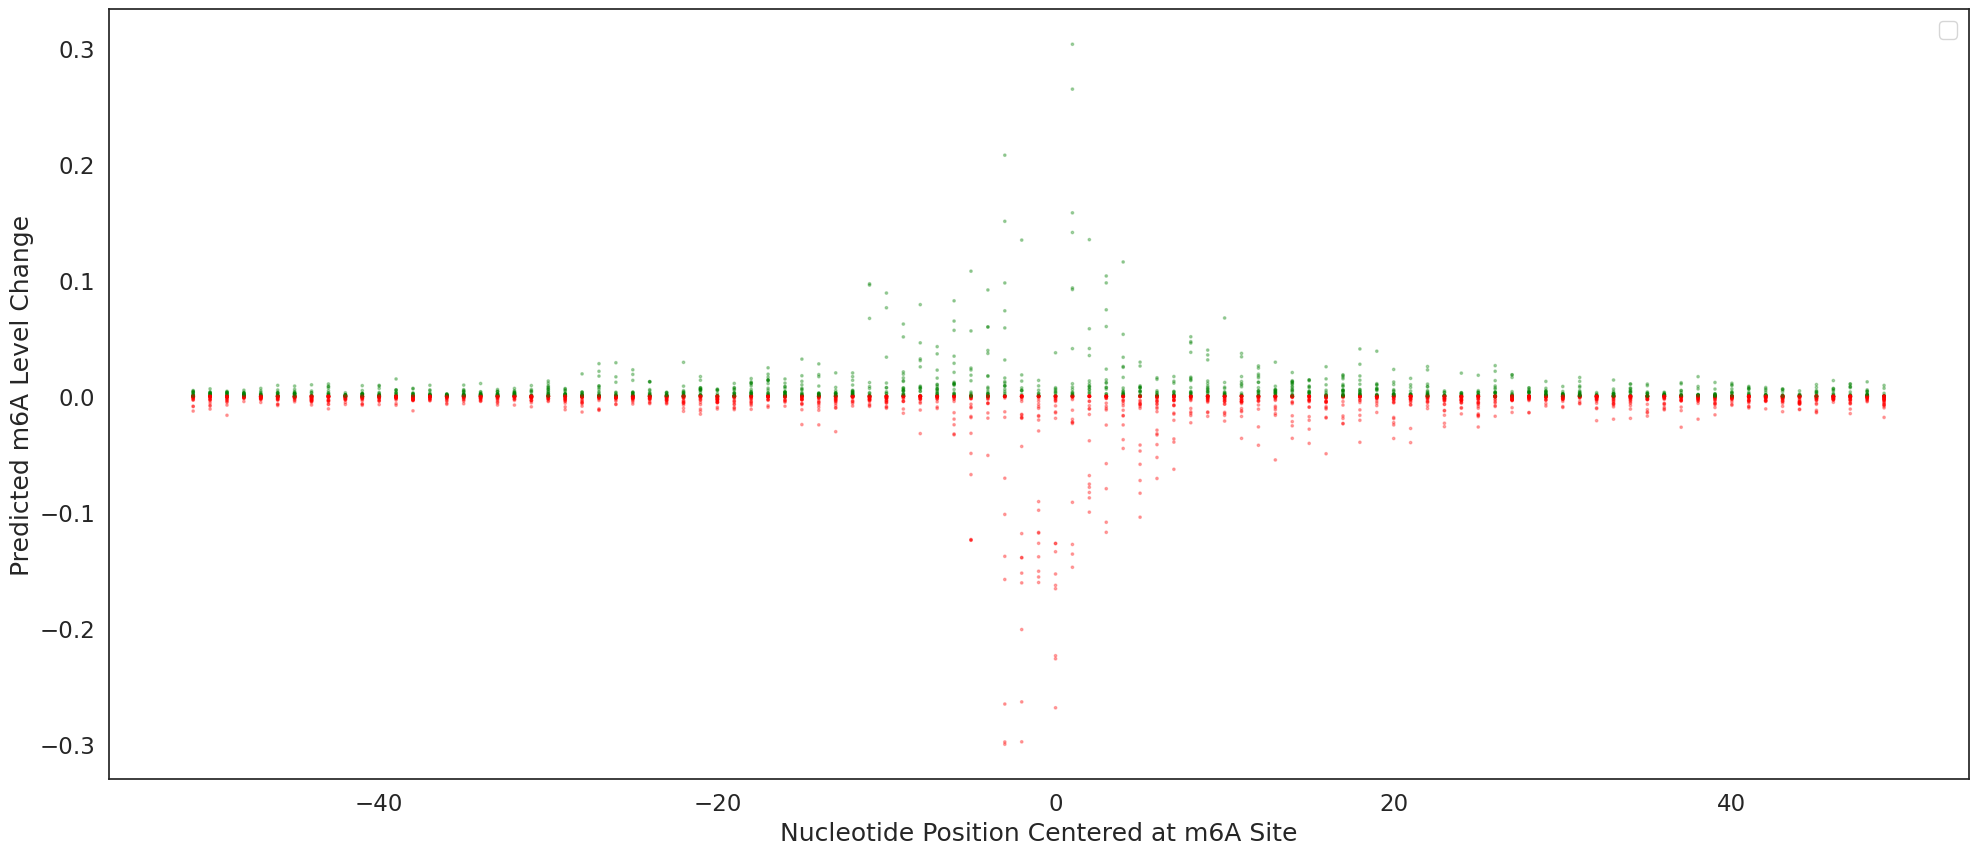

In [327]:
plot_ism_scatter(y_delta[1:10,:,:,:], 1, slice_start = 450, slice_end = 551)

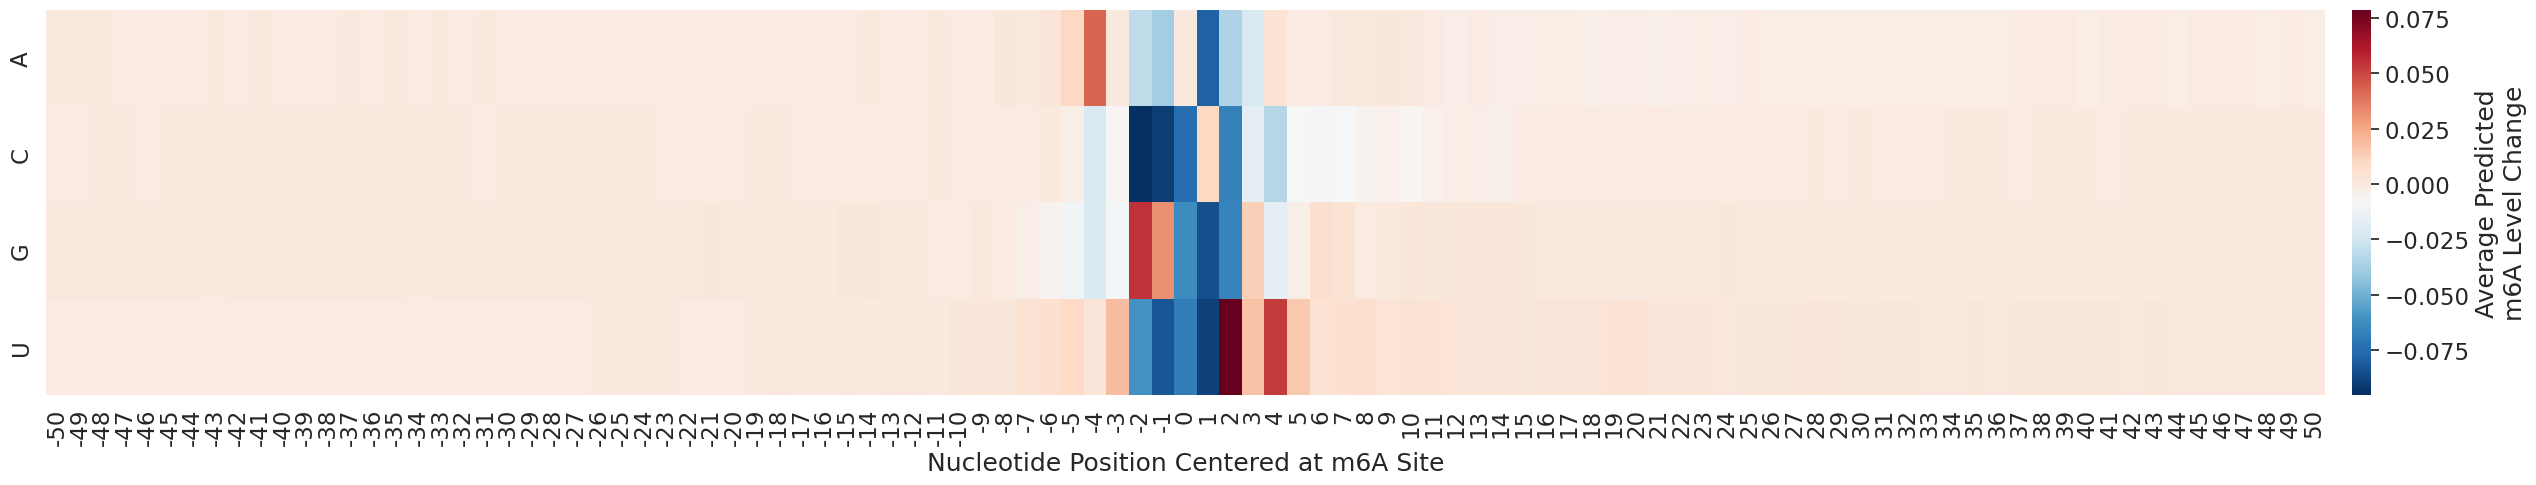

In [280]:
y_delta[:,:,:,1].shape
slice_start = 450
slice_end = 551
plot_df = pd.DataFrame(torch.mean(y_delta[:,:,:,1], dim=0).numpy().T, columns=list("ACGU"))

fig, ax = plt.subplots(figsize=(35, 5))

sns.set(font_scale=1.5)
s = sns.heatmap(data=(plot_df.T).iloc[:,slice_start:slice_end], xticklabels=list(range(slice_start-500,slice_end-500)), cmap="RdBu_r", cbar_kws={"pad": 0.01, "label":"Average Predicted\nm6A Level Change"})
s.set(xlabel='Nucleotide Position Centered at m6A Site')

plt.savefig(f"ism/hypox_avg_score_ism_fold_{fold}.png",bbox_inches='tight')

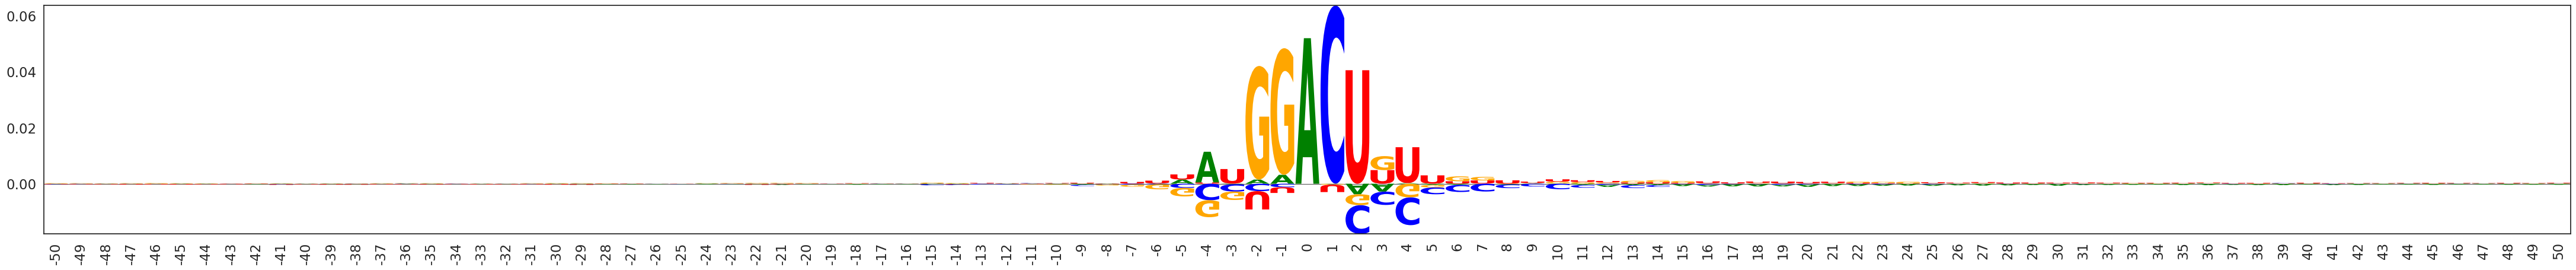

In [317]:
slice_start = 450
slice_end = 551
attr = attribution_score(y_ref, y_ism, 1)
attr = attr * seq_fasta_one_hot[list(selected_sequences),:,:]
plot_logo = np.average(attr, axis=0)
plot_logo_df = pd.DataFrame(plot_logo.T, columns=list("ACGU"))
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo((plot_logo_df).iloc[slice_start:slice_end], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
ax.set_facecolor("white")
plt.grid(False)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 16})
plt.xticks(list(range(slice_start, slice_end)), list(range(slice_start-500, slice_end-500)))  
plt.savefig(f"ism/hypox_logo_ism_fold_{fold}.png" ,bbox_inches='tight')
plt.show()

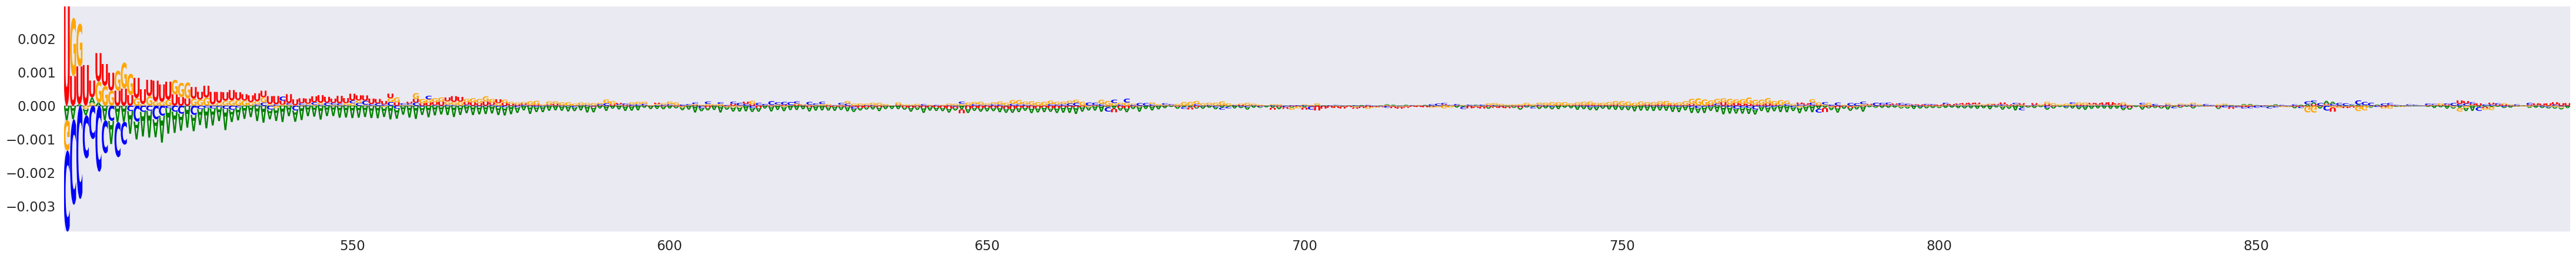

In [294]:

fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo((plot_logo_df).iloc[505:900], ax=ax, color_scheme='classic')
plt.show()

NOTE: Running for each fold could take around 130 minutes for each fold even with CUDA due to numerous mutations it creates

ISM Analysis:   0%|          | 0/4 [00:00<?, ?it/s]

Starting ISM Analysis...
Saving...
Saving Done


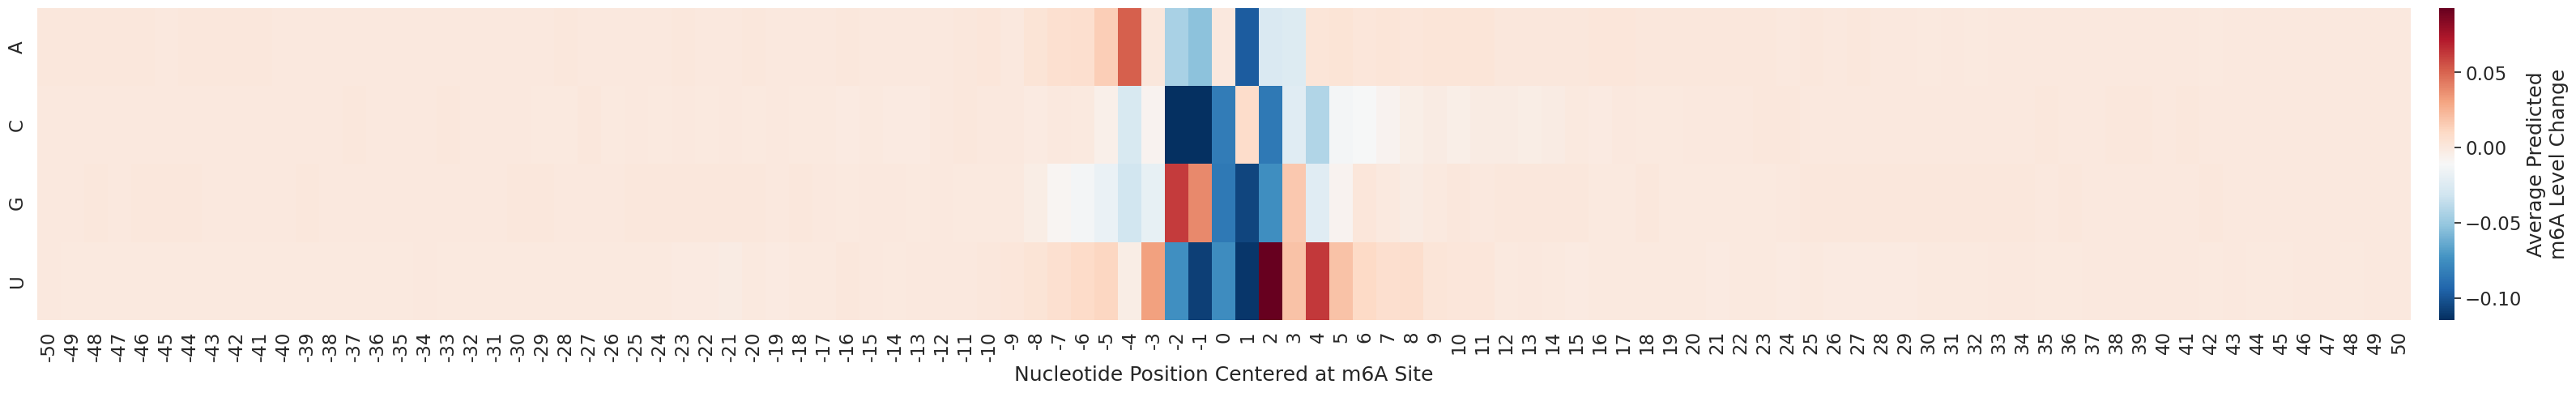

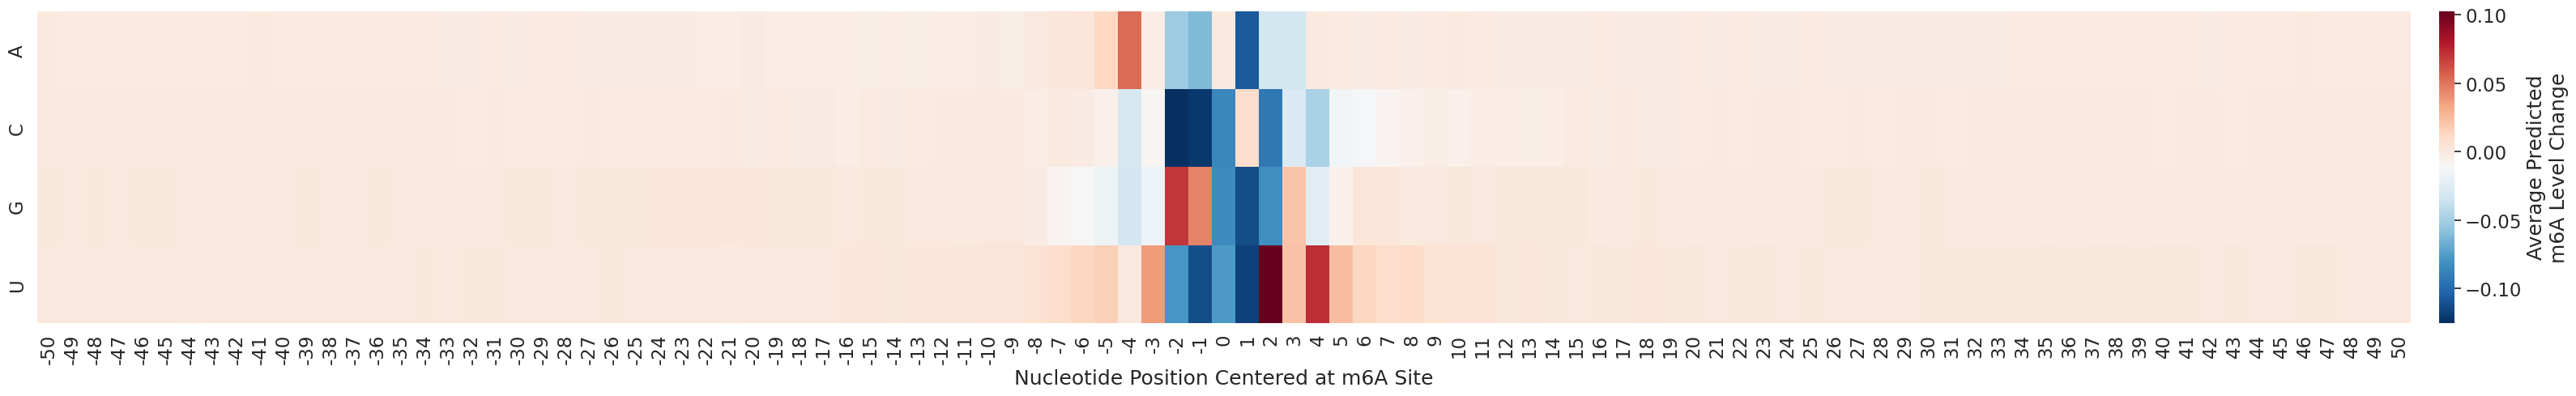

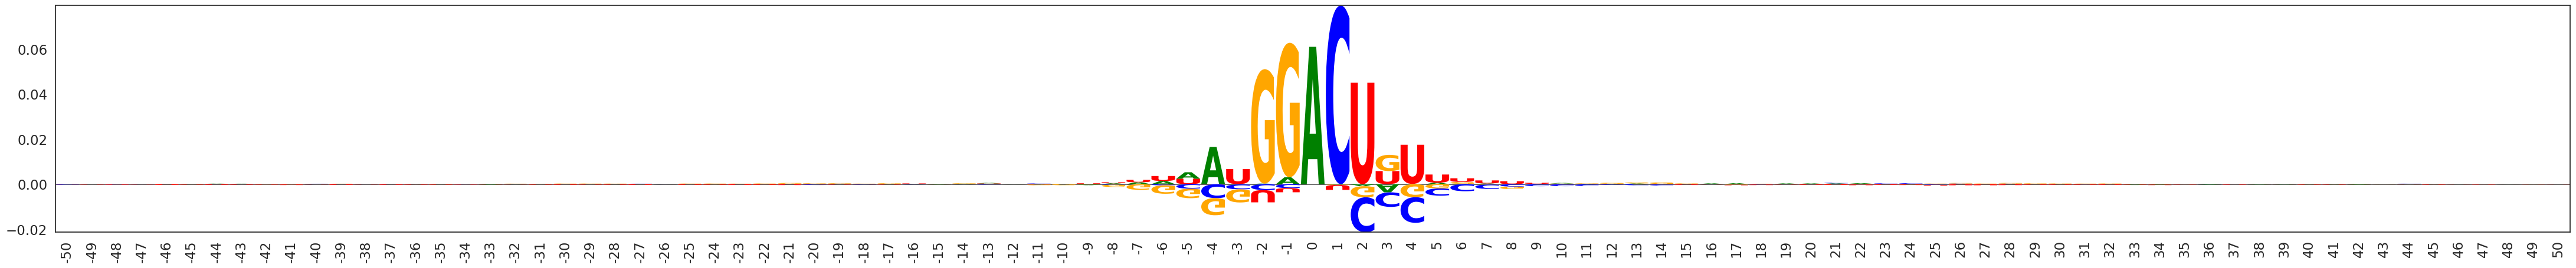

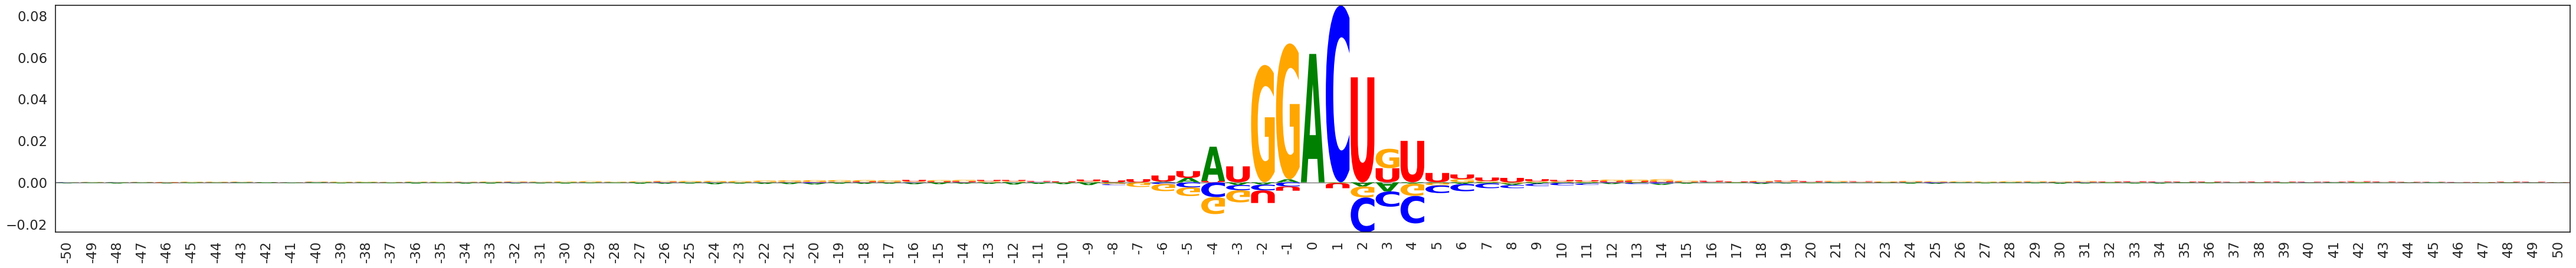

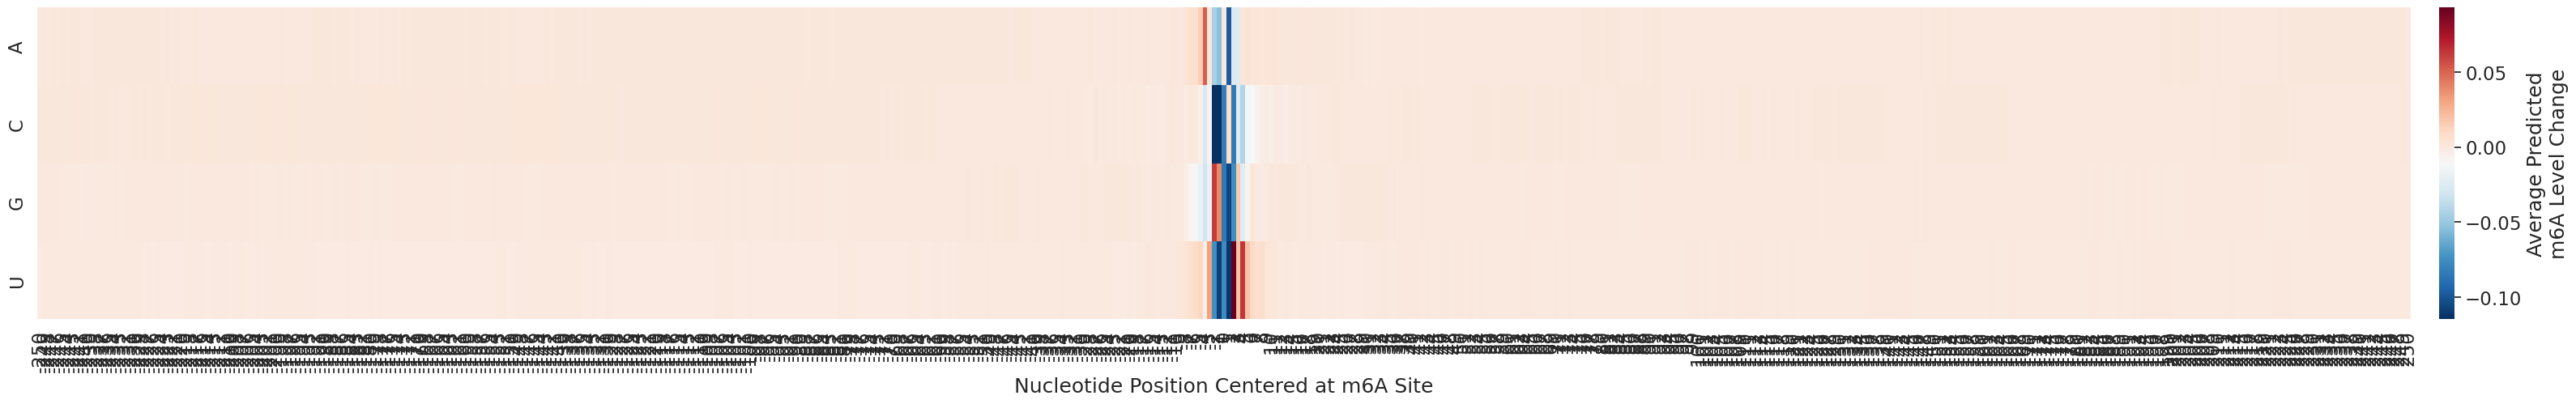

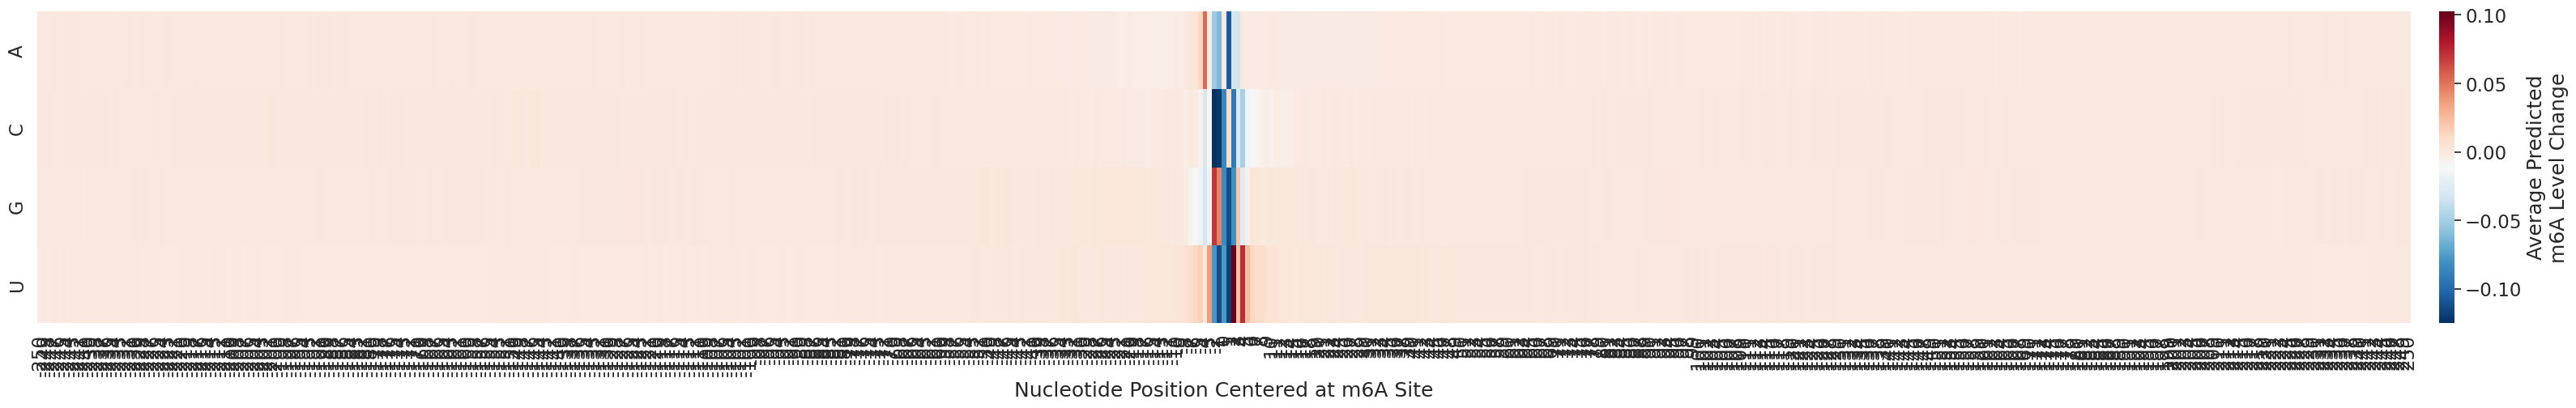

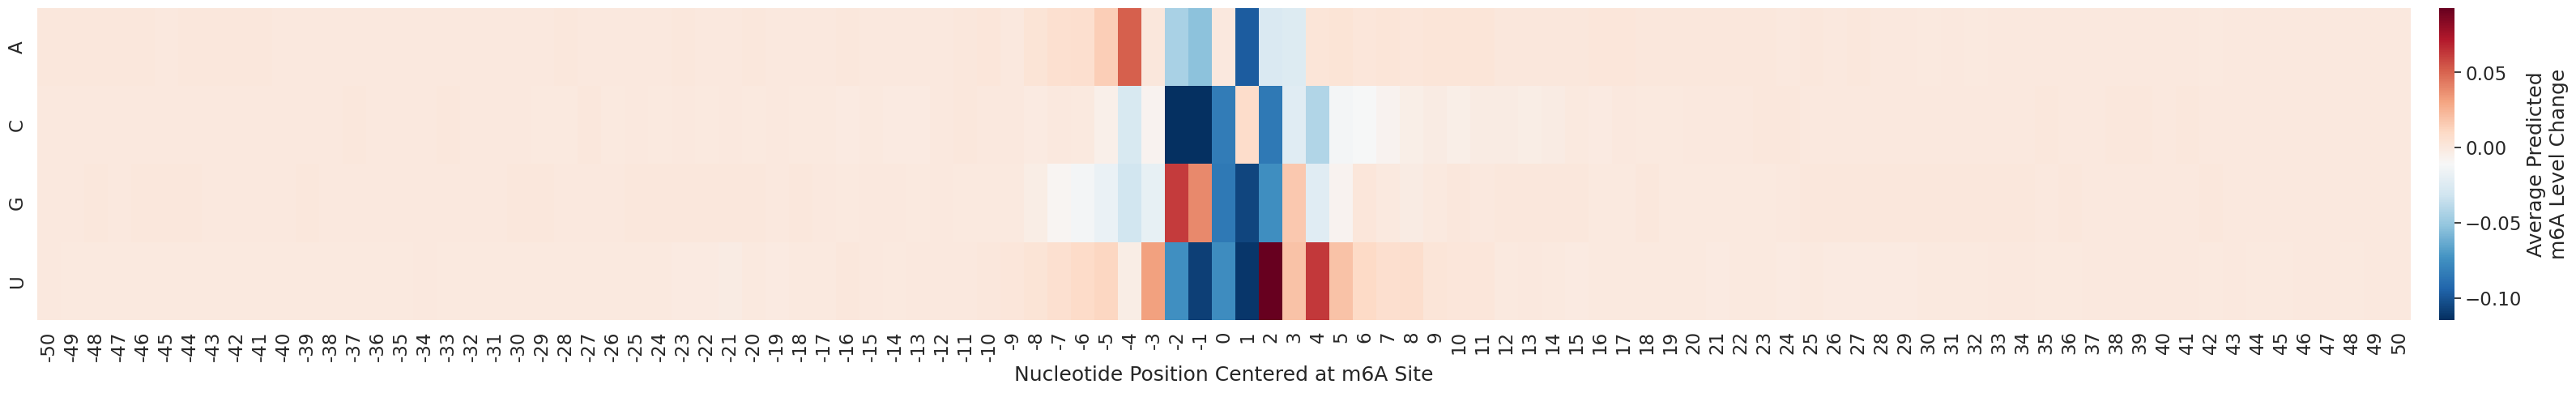

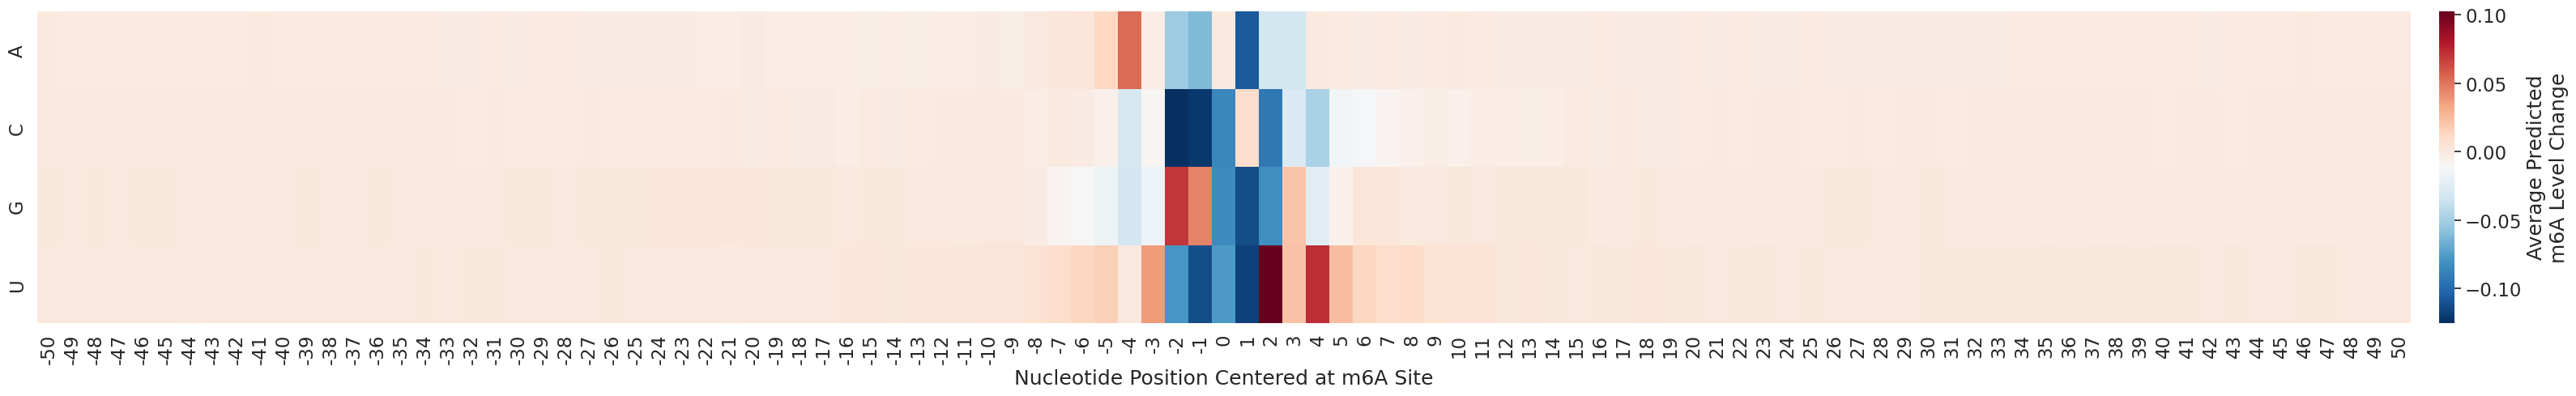

ISM Analysis:  25%|██▌       | 1/4 [2:15:12<6:45:37, 8112.56s/it]

Finished ISM Analysis...
Starting ISM Analysis...
Saving...
Saving Done


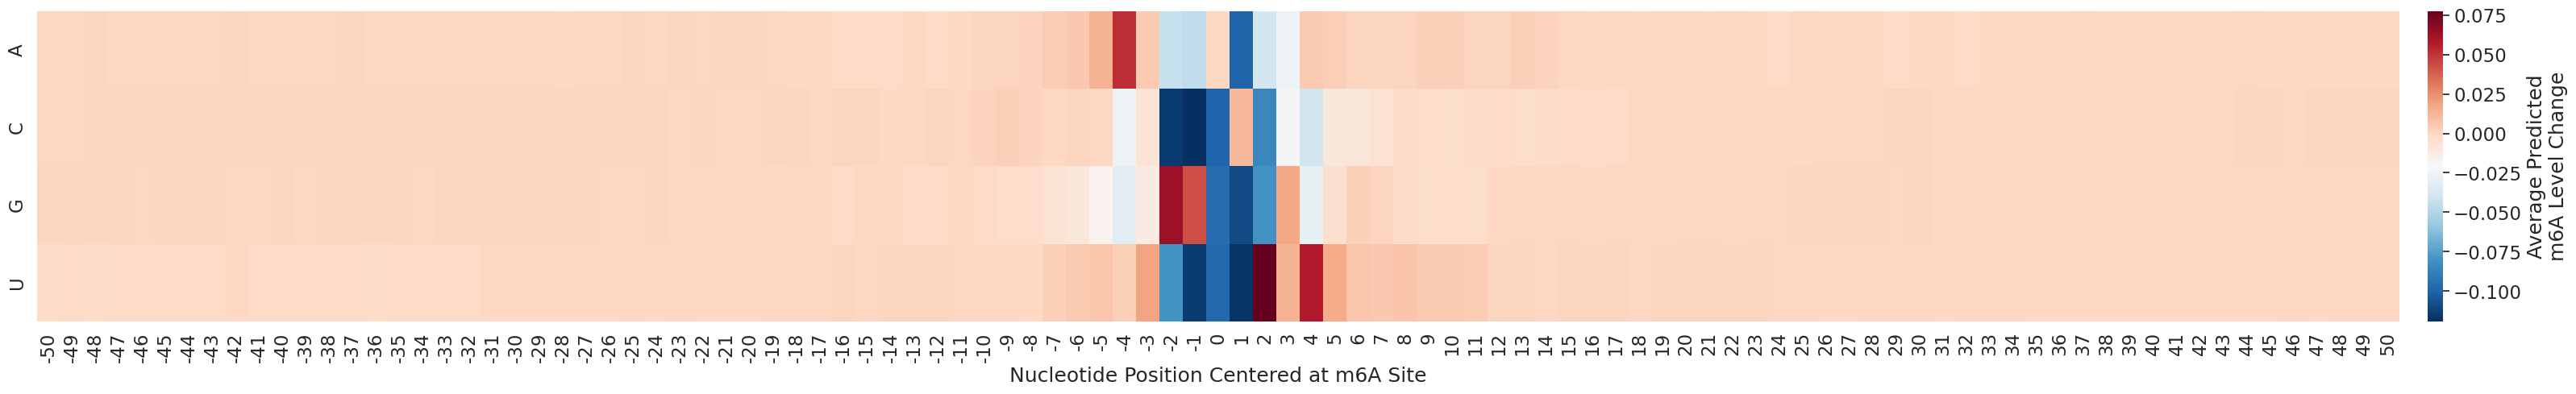

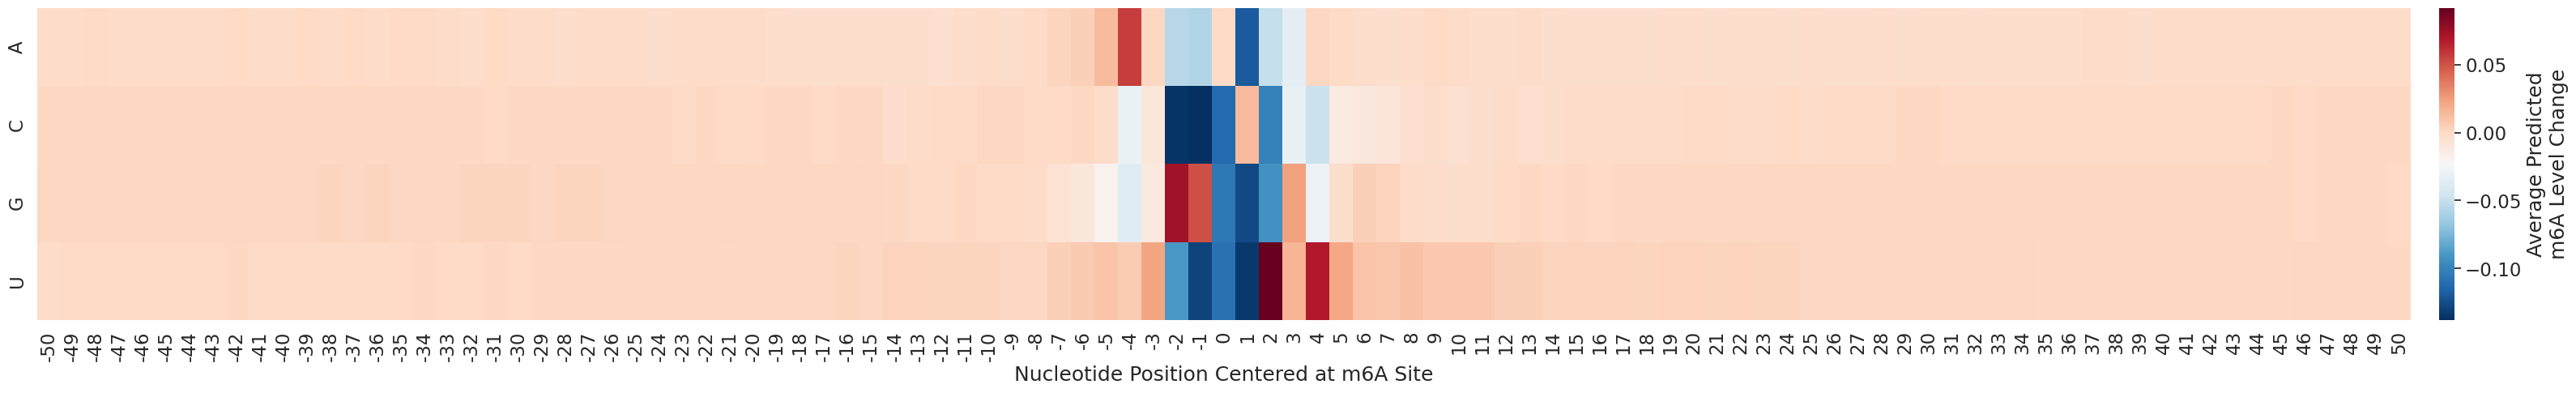

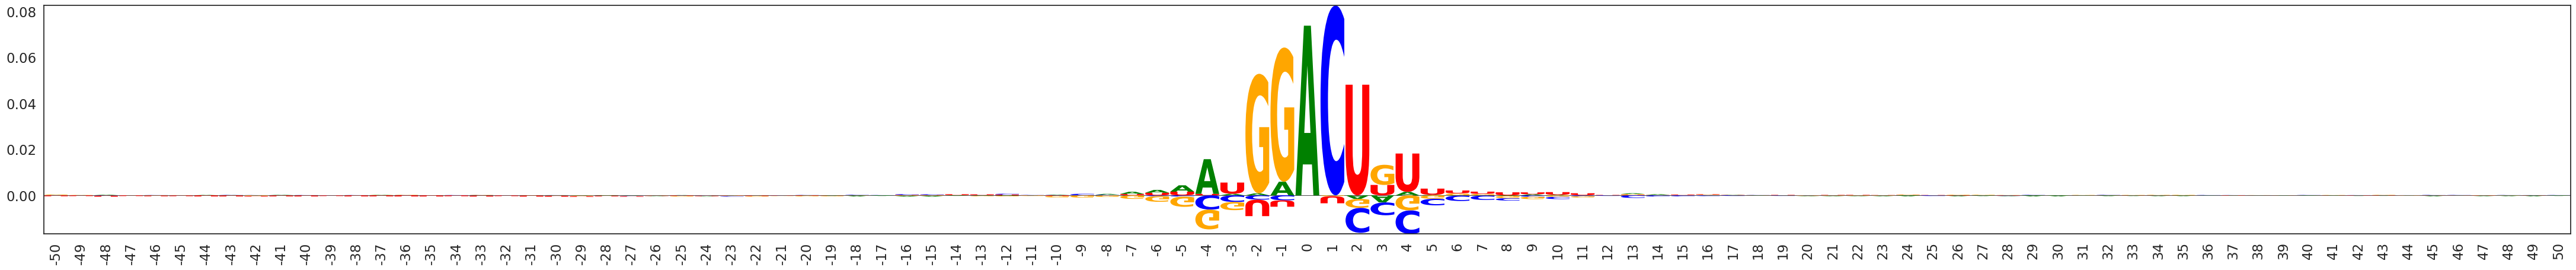

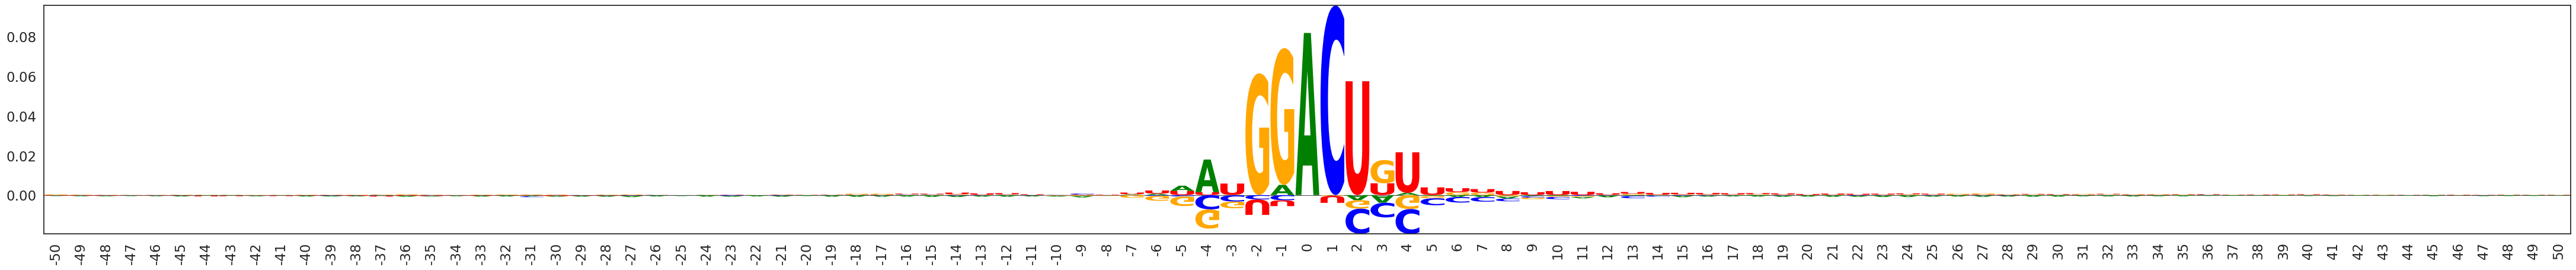

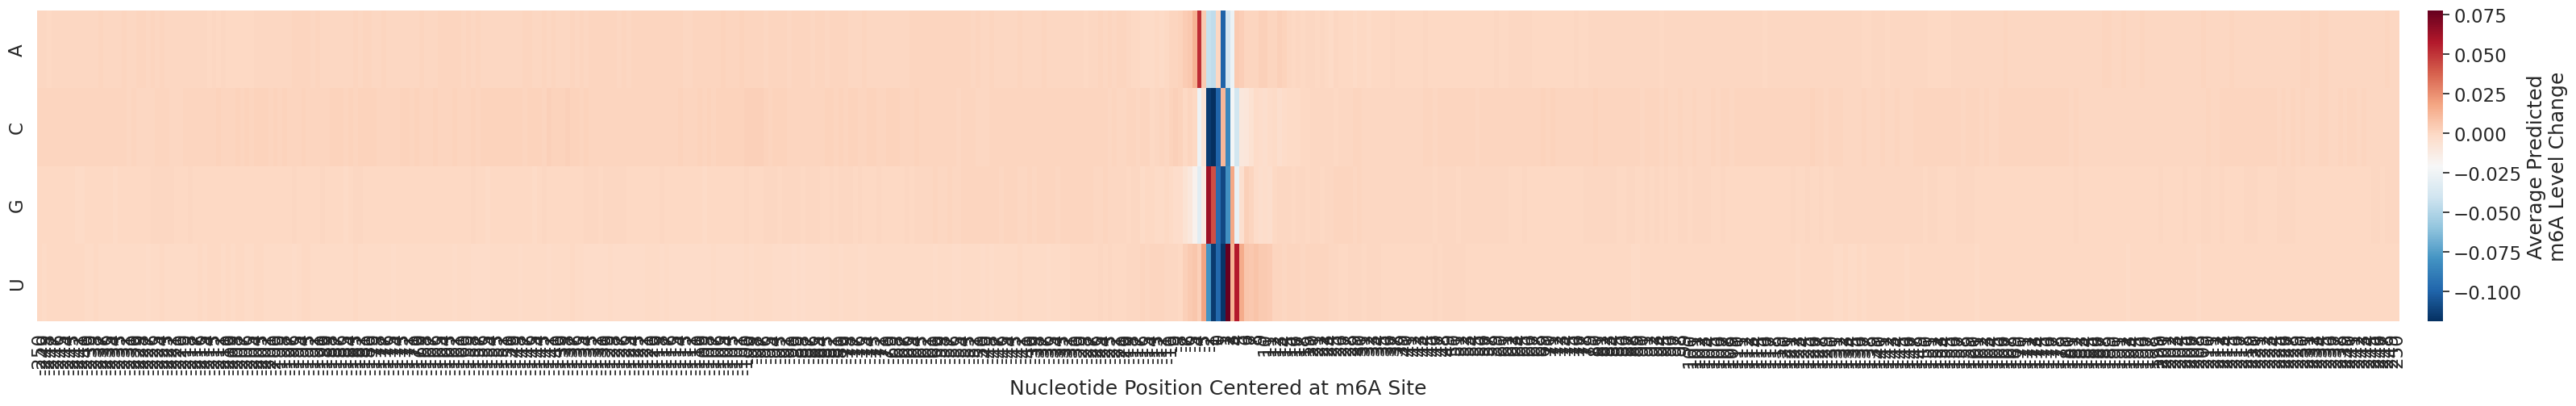

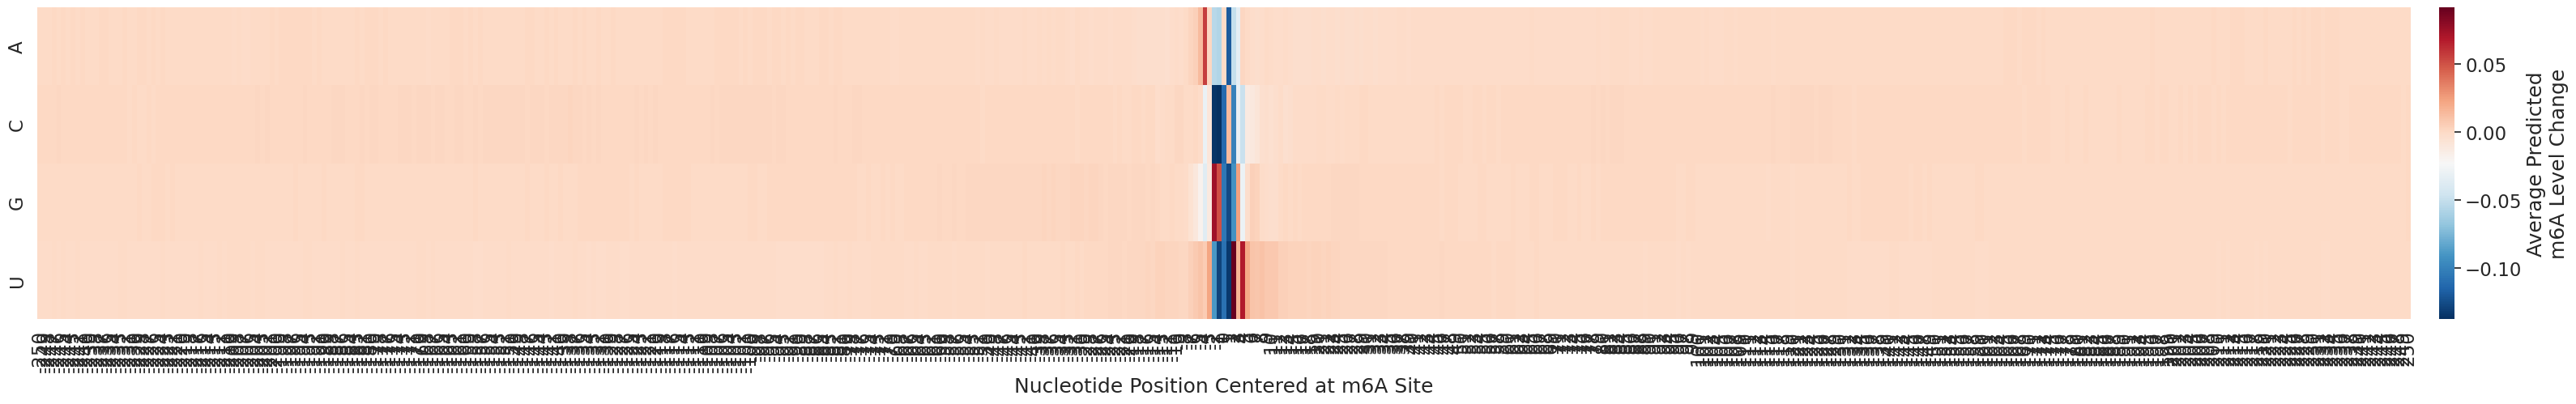

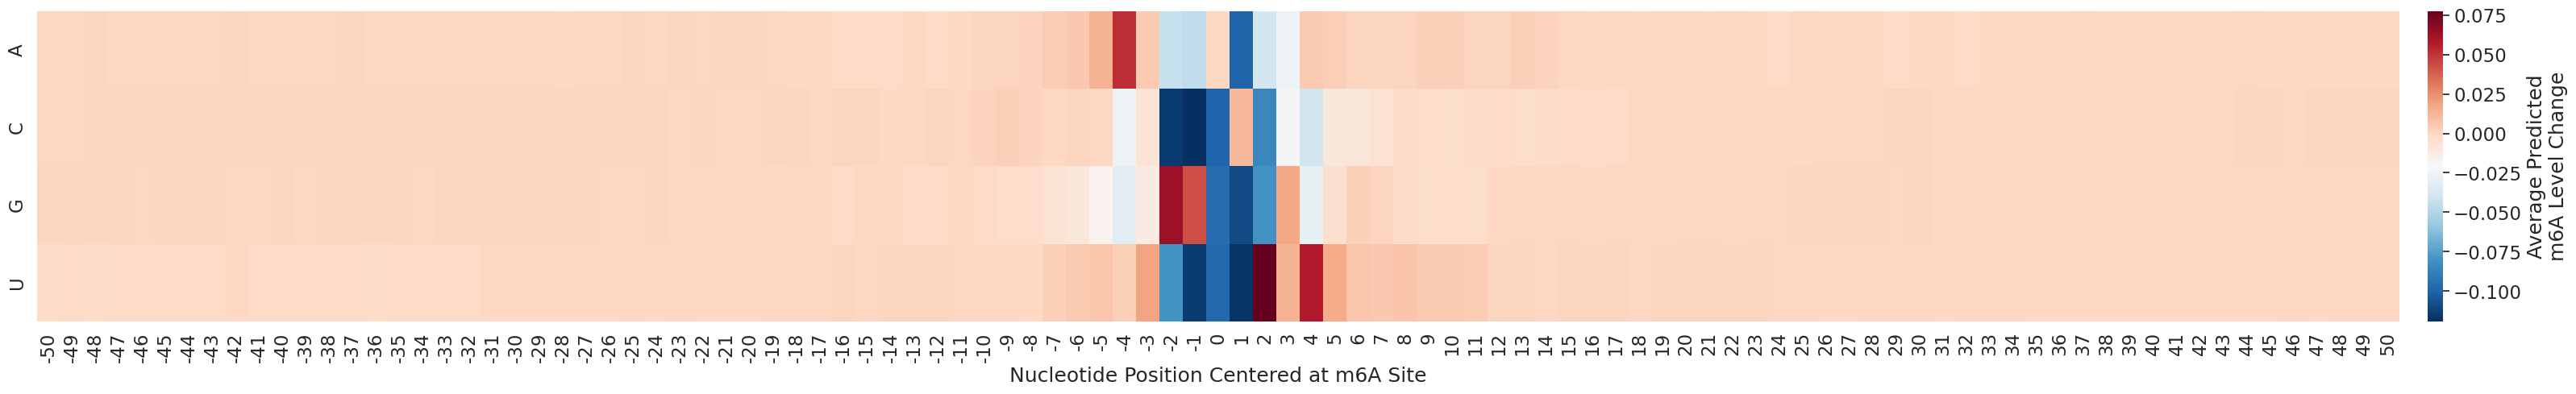

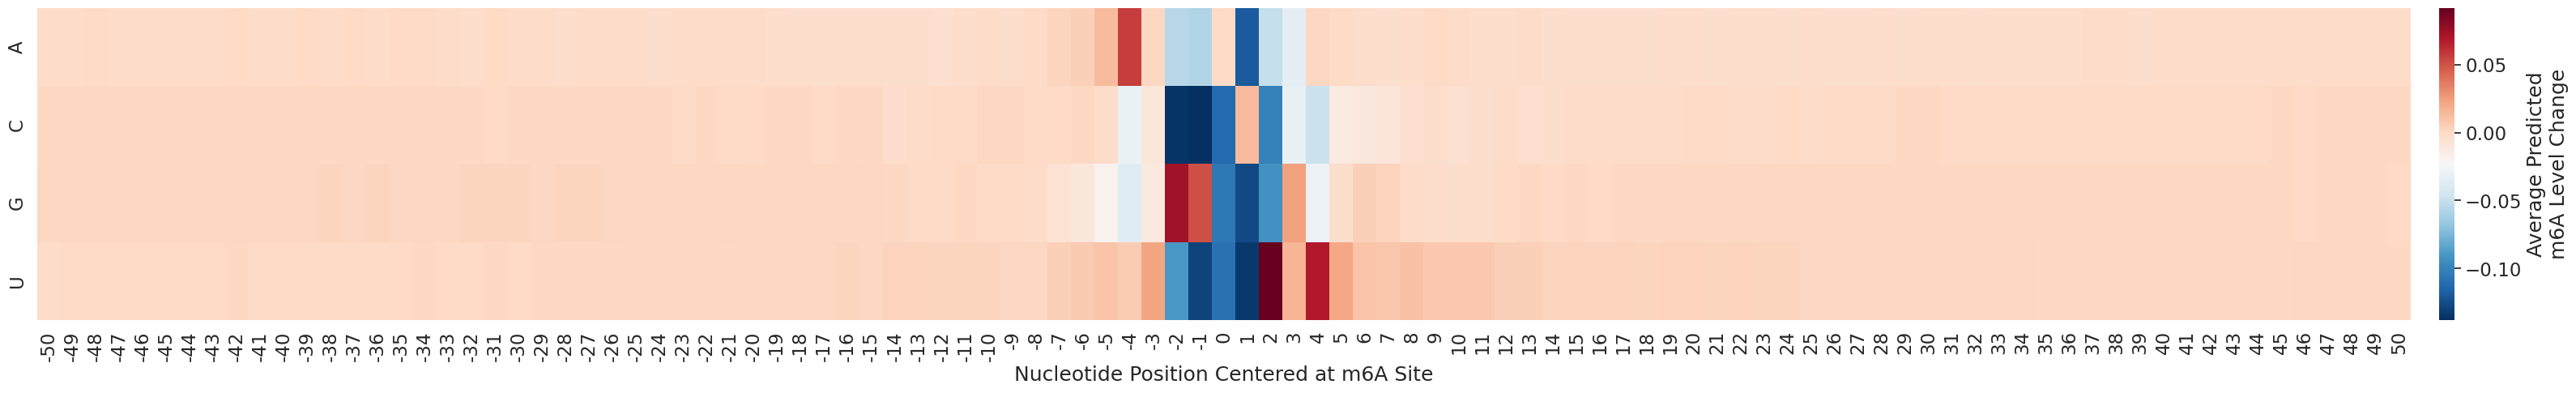

ISM Analysis:  50%|█████     | 2/4 [4:34:00<4:34:38, 8239.34s/it]

Finished ISM Analysis...
Starting ISM Analysis...
Saving...
Saving Done


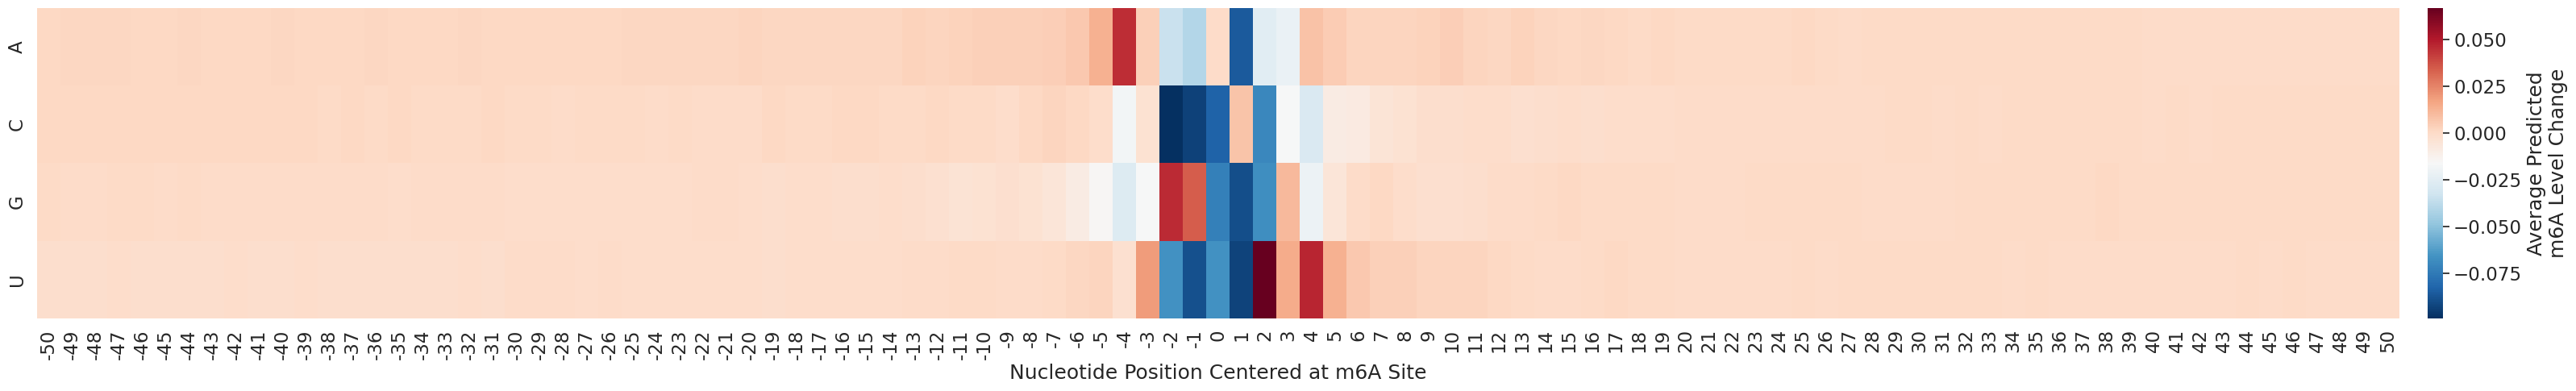

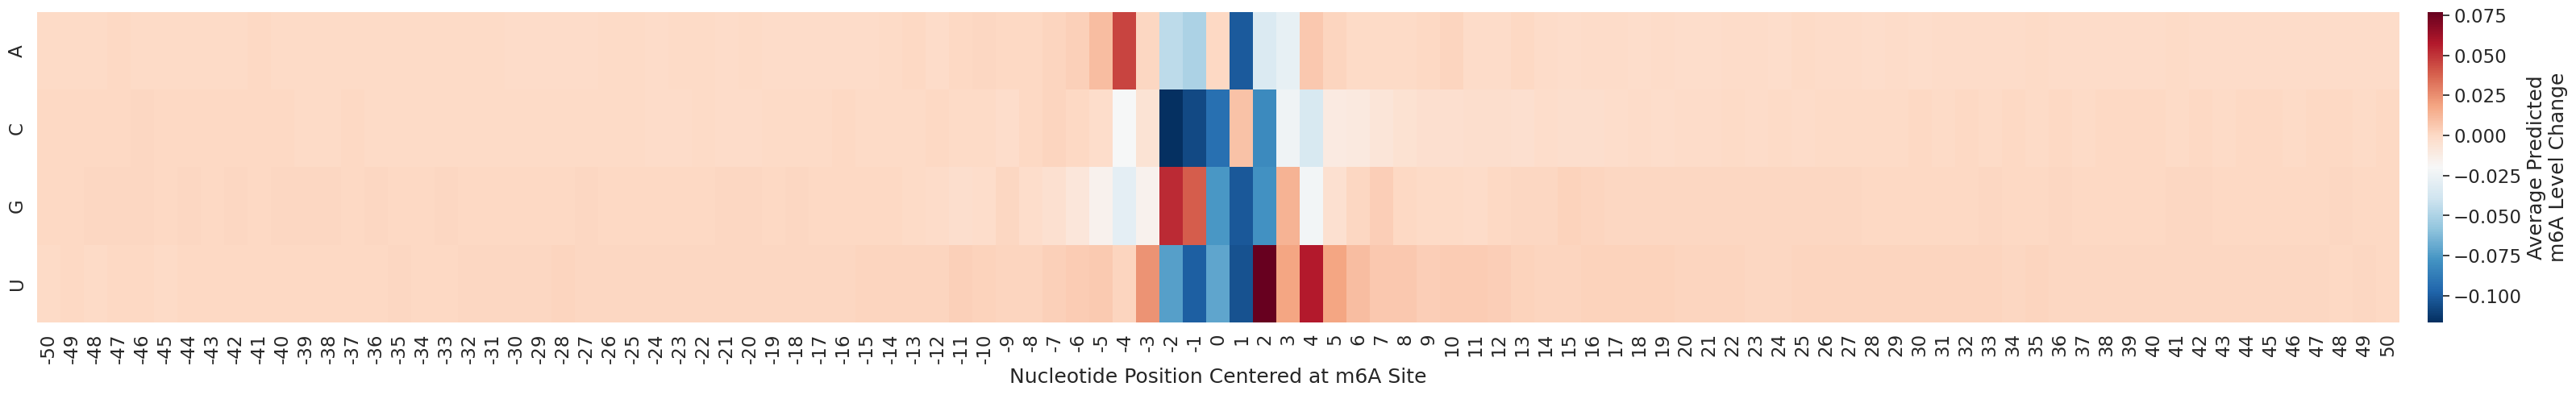

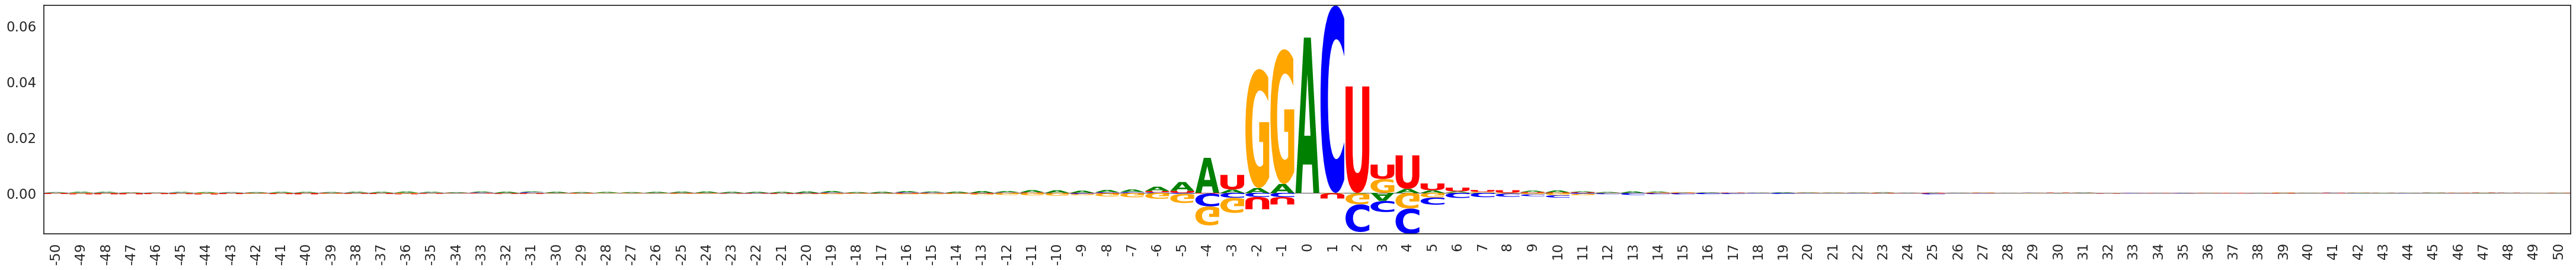

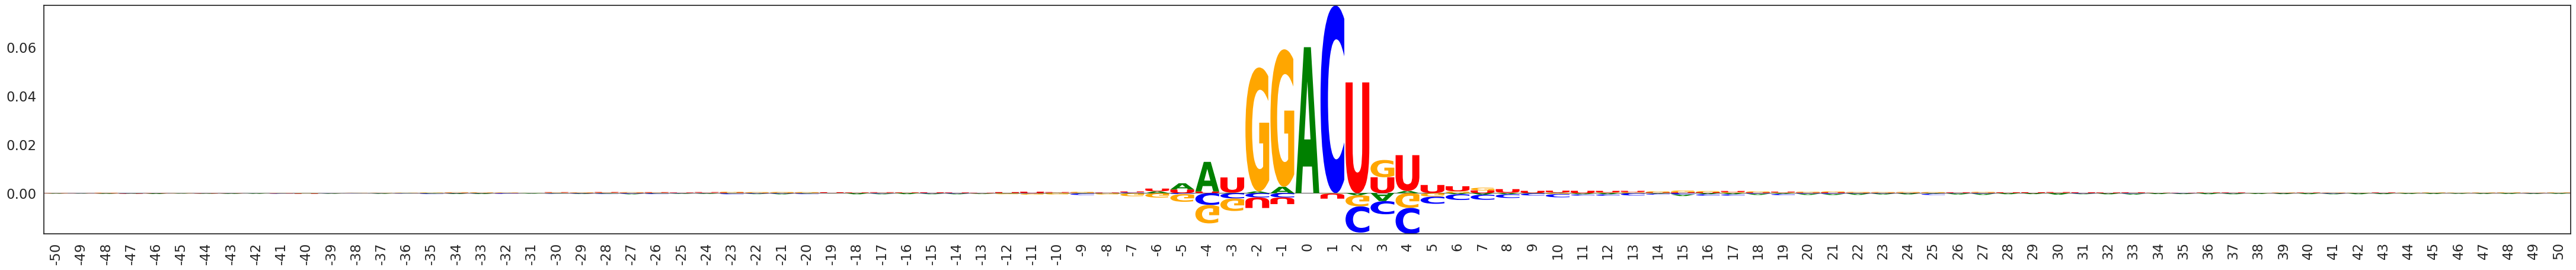

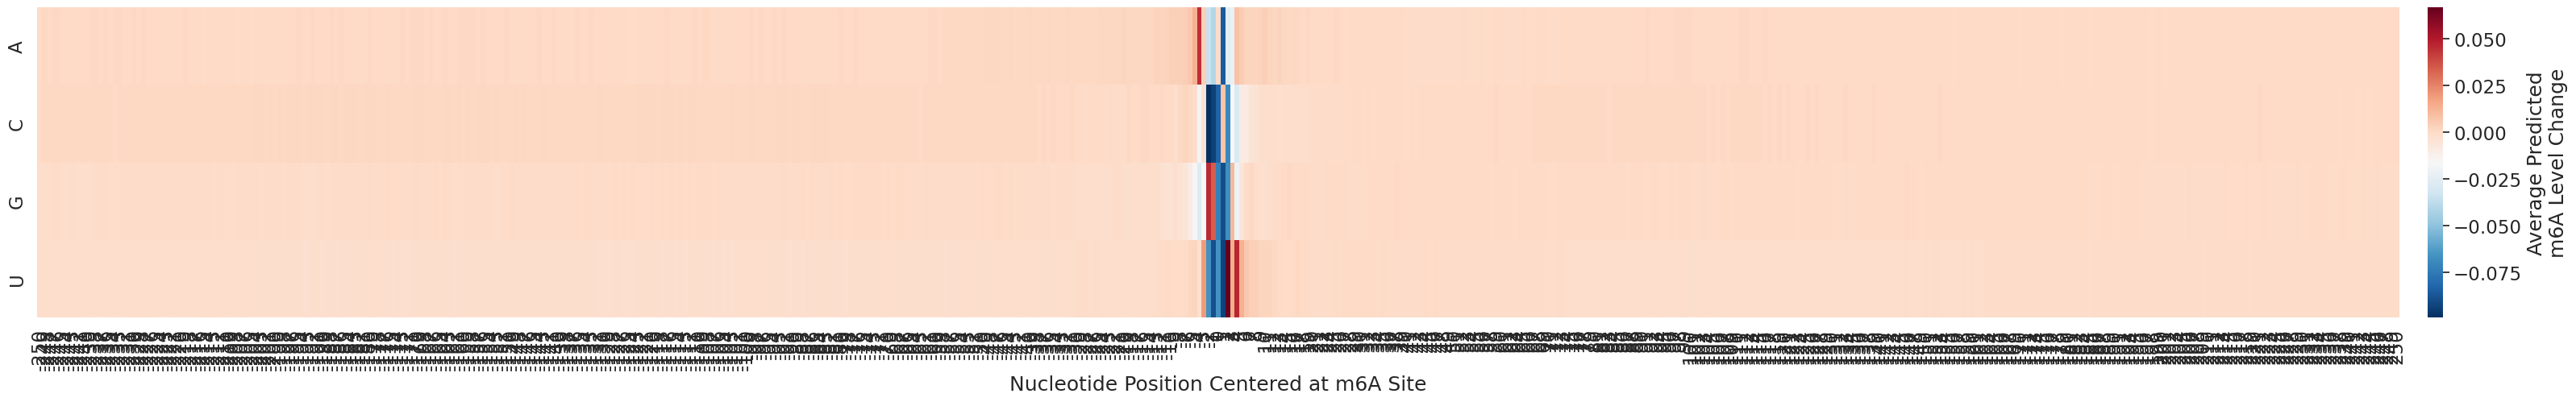

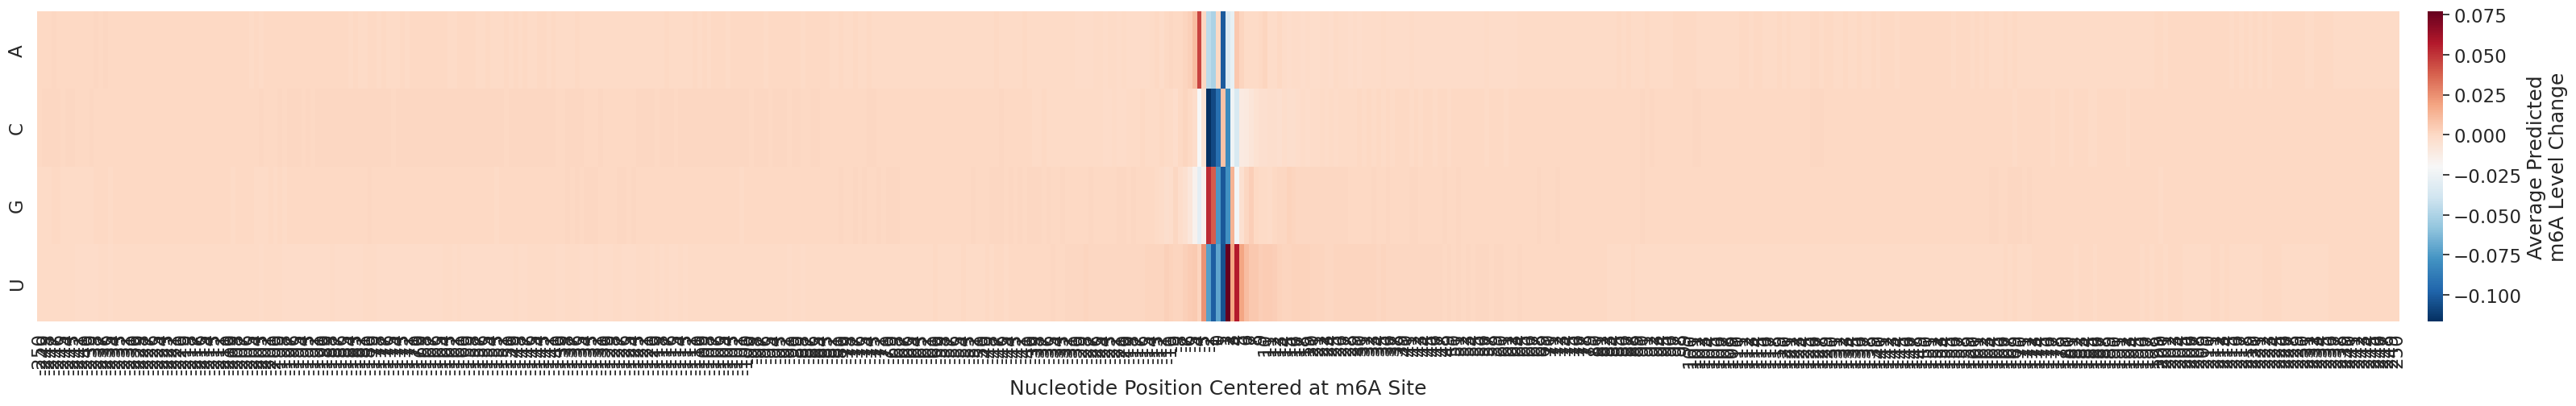

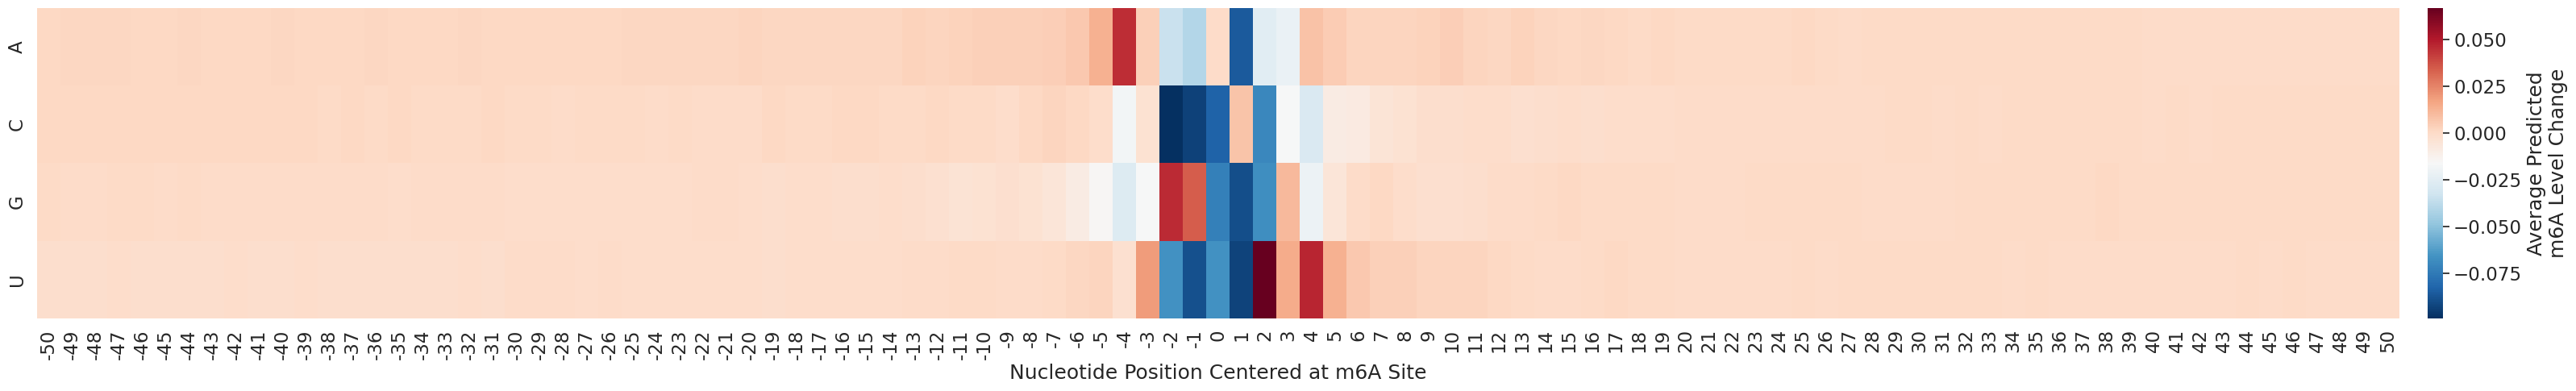

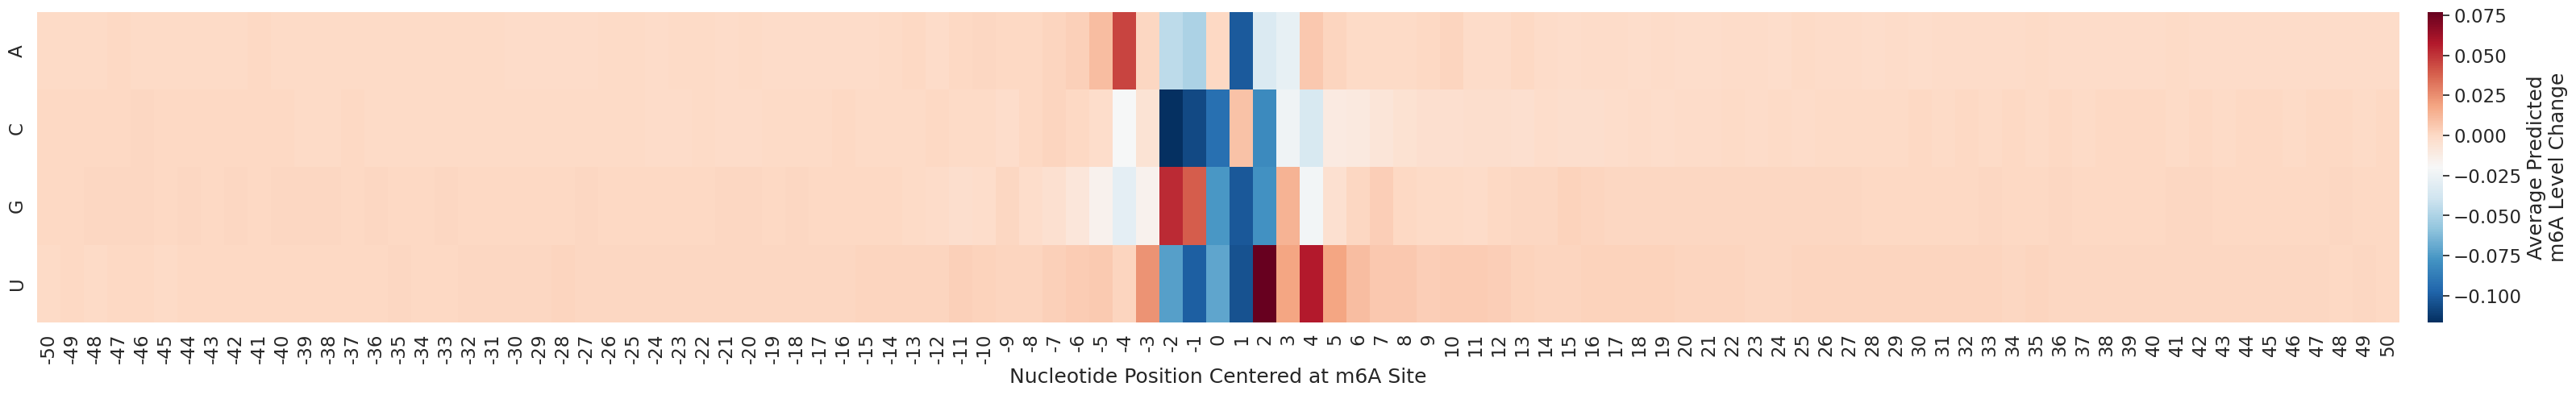

ISM Analysis:  75%|███████▌  | 3/4 [6:51:32<2:17:25, 8245.24s/it]

Finished ISM Analysis...
Starting ISM Analysis...
Saving...
Saving Done


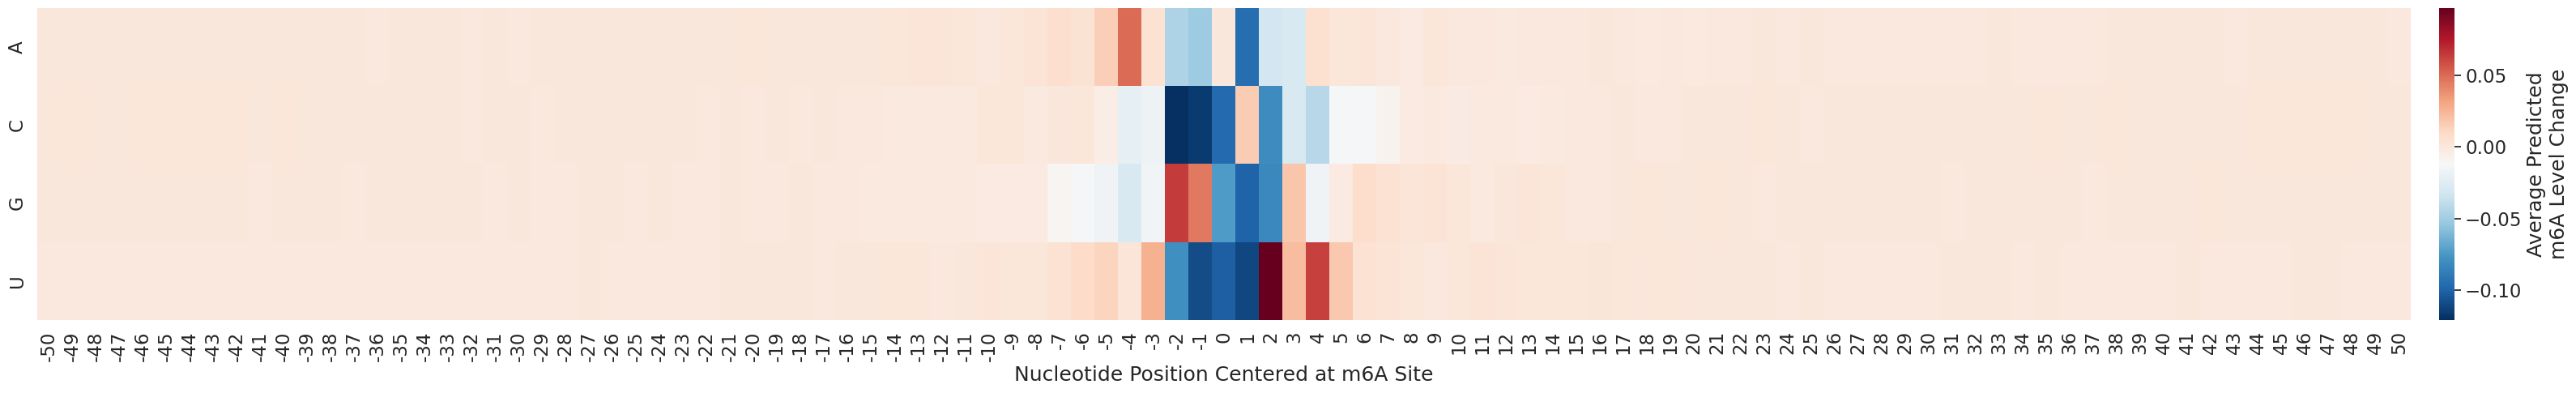

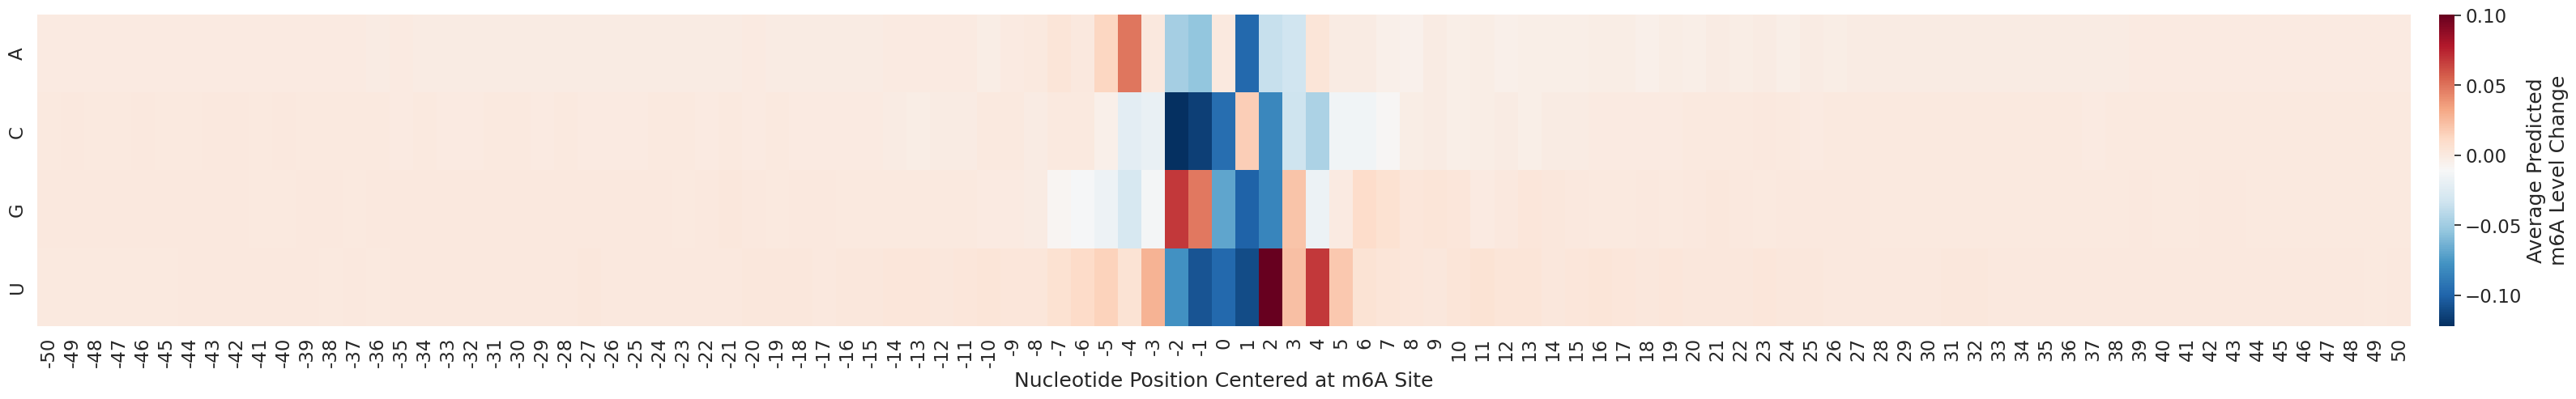

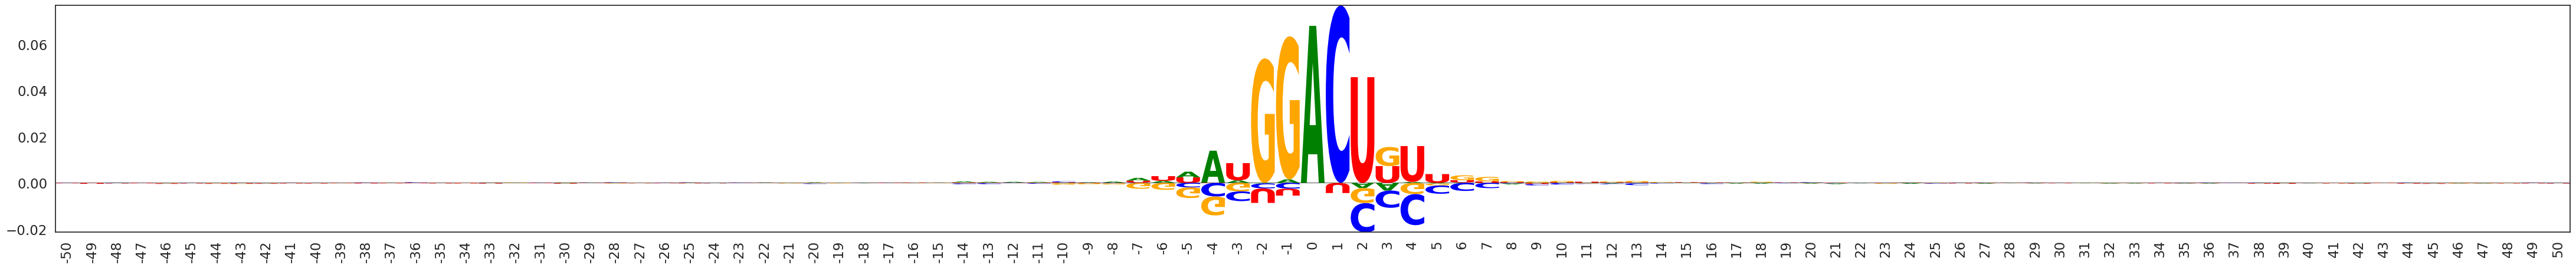

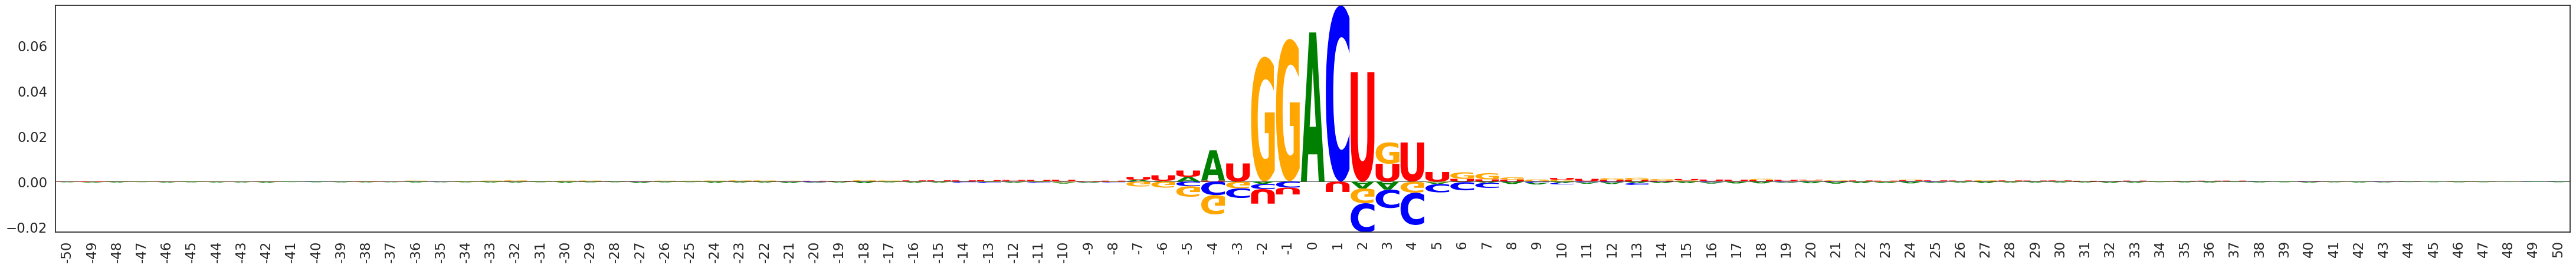

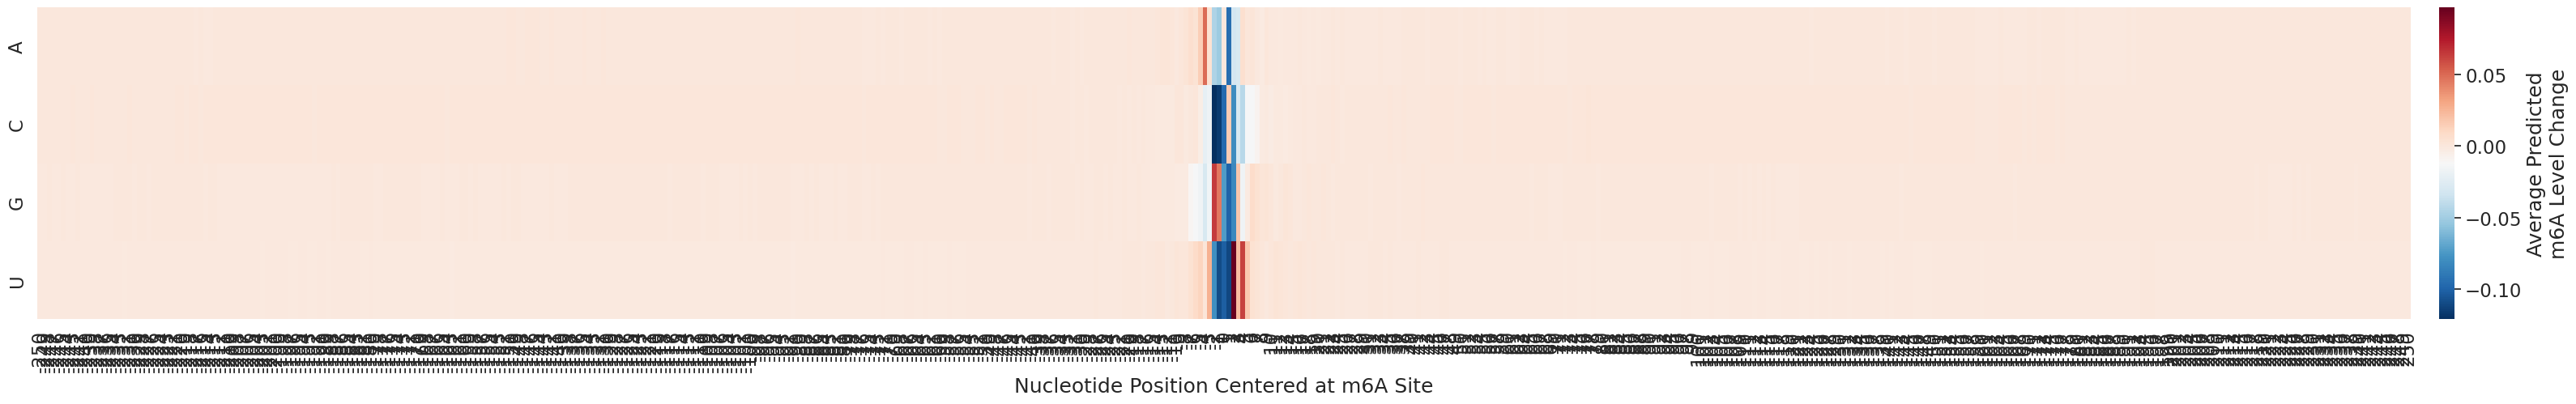

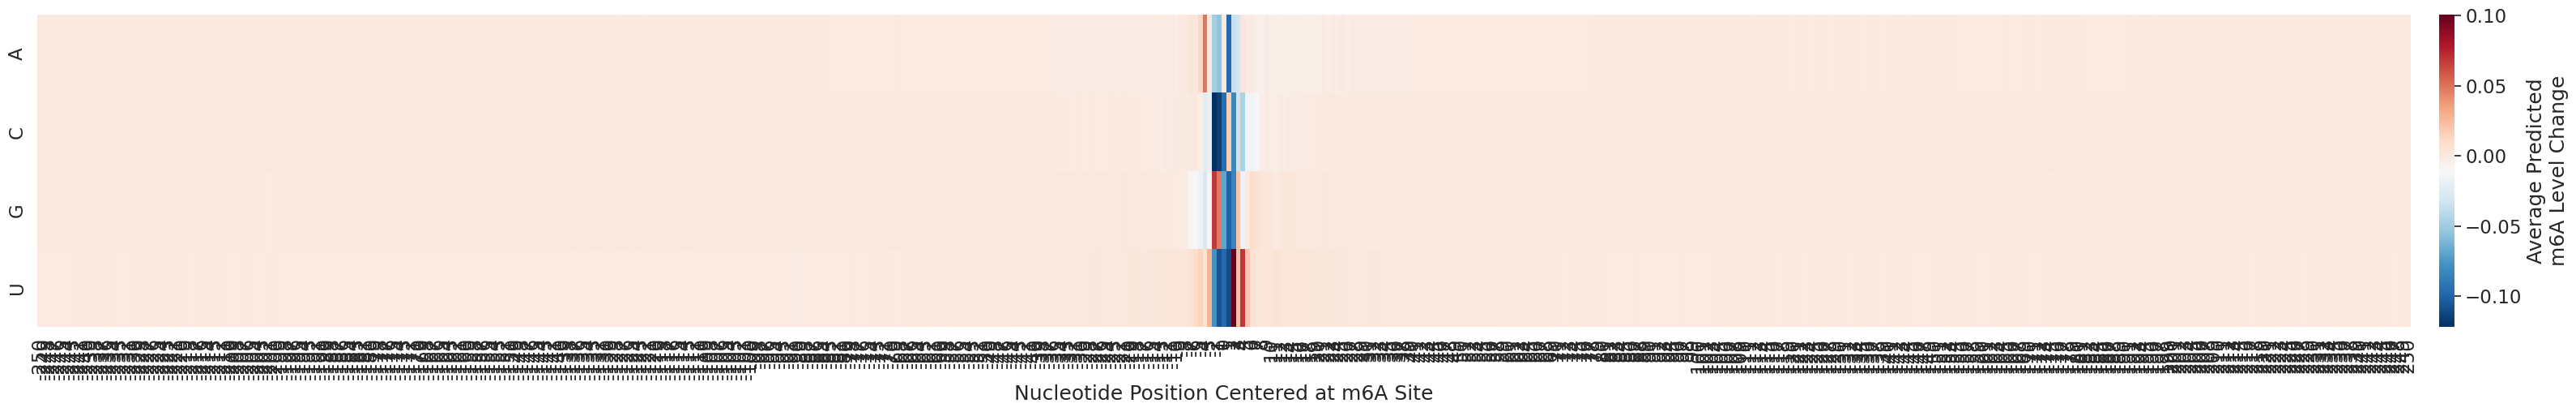

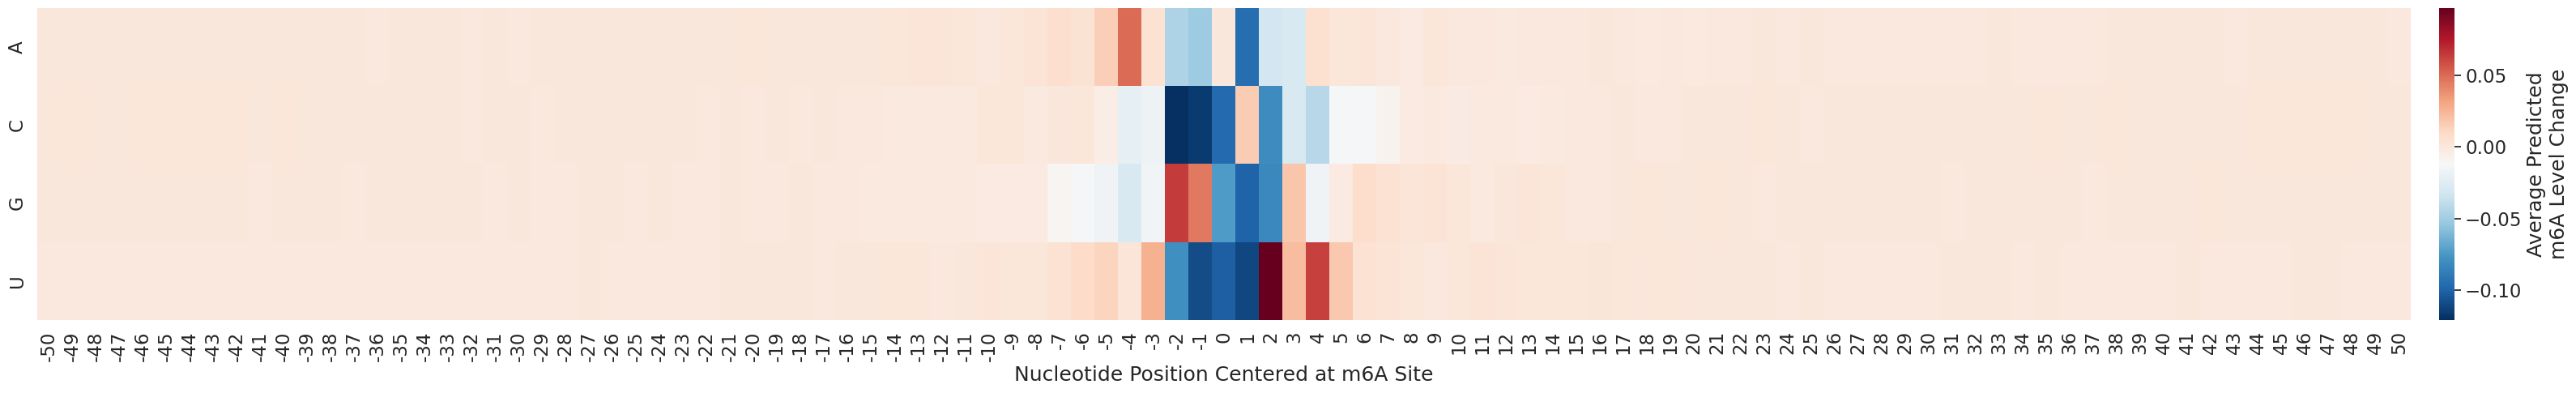

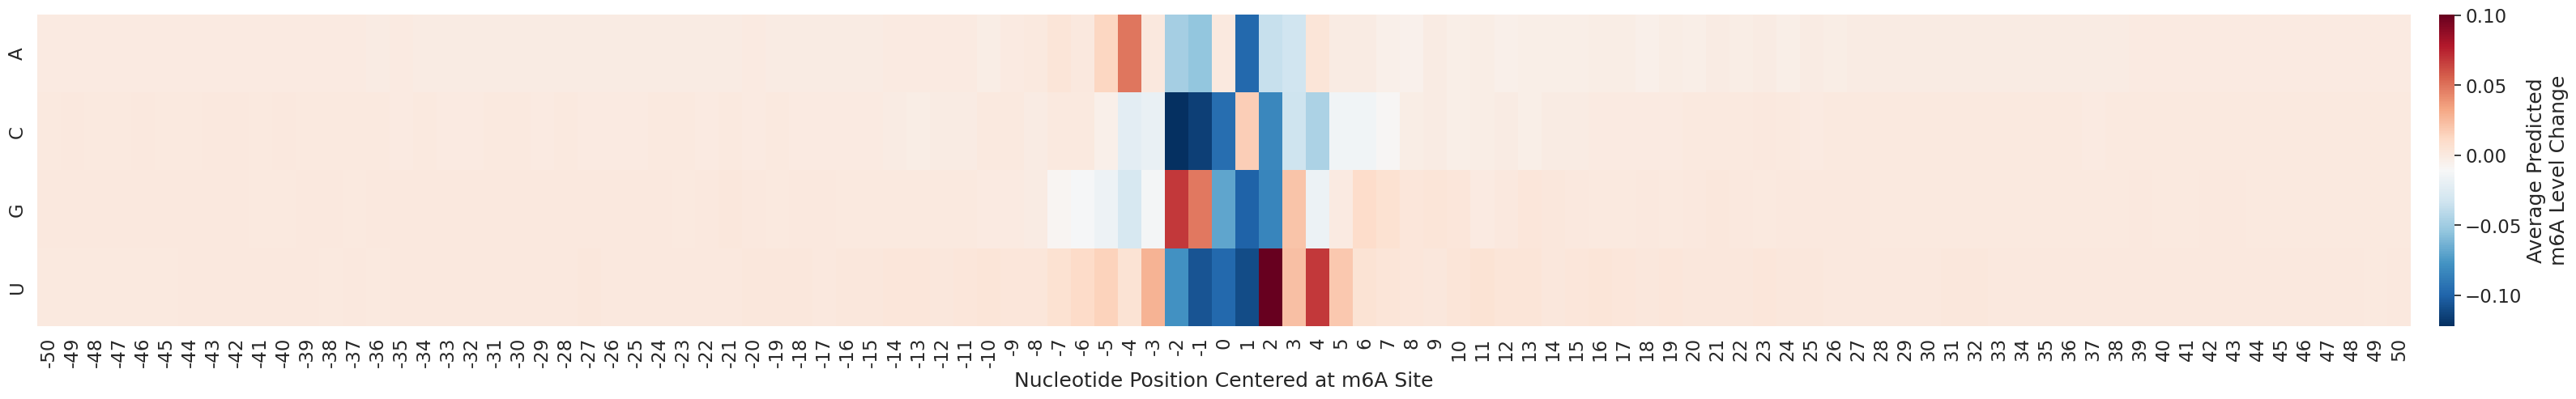

ISM Analysis: 100%|██████████| 4/4 [9:09:31<00:00, 8242.87s/it]  

Finished ISM Analysis...


In [340]:
PROJECT_PATH = "/binf-isilon/renniegrp/vpx267/ucph_thesis"
for fold in tqdm(range(2,6), desc=f"ISM Analysis"): 
    model_weight = torch.load(f"{PROJECT_PATH}/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.pkl",
                            map_location=torch.device('cpu'))
    model.load_state_dict(model_weight)
    model.eval()
    meta_data_test_json_path = f"{PROJECT_PATH}/data/dual_outputs/test_meta_data_SPLIT_{fold}.json"
    seq_fasta_test_path = f"{PROJECT_PATH}/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    valid_data = pd.read_csv(f"{PROJECT_PATH}/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

    valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2

    # Select the top 2000 sequences with lowest average MSE
    selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]
    print("Starting ISM Analysis...")
    ism_analysis(model=model, input_sequences=seq_fasta_one_hot[list(selected_sequences),:,:], fold=fold)
    print("Finished ISM Analysis...")

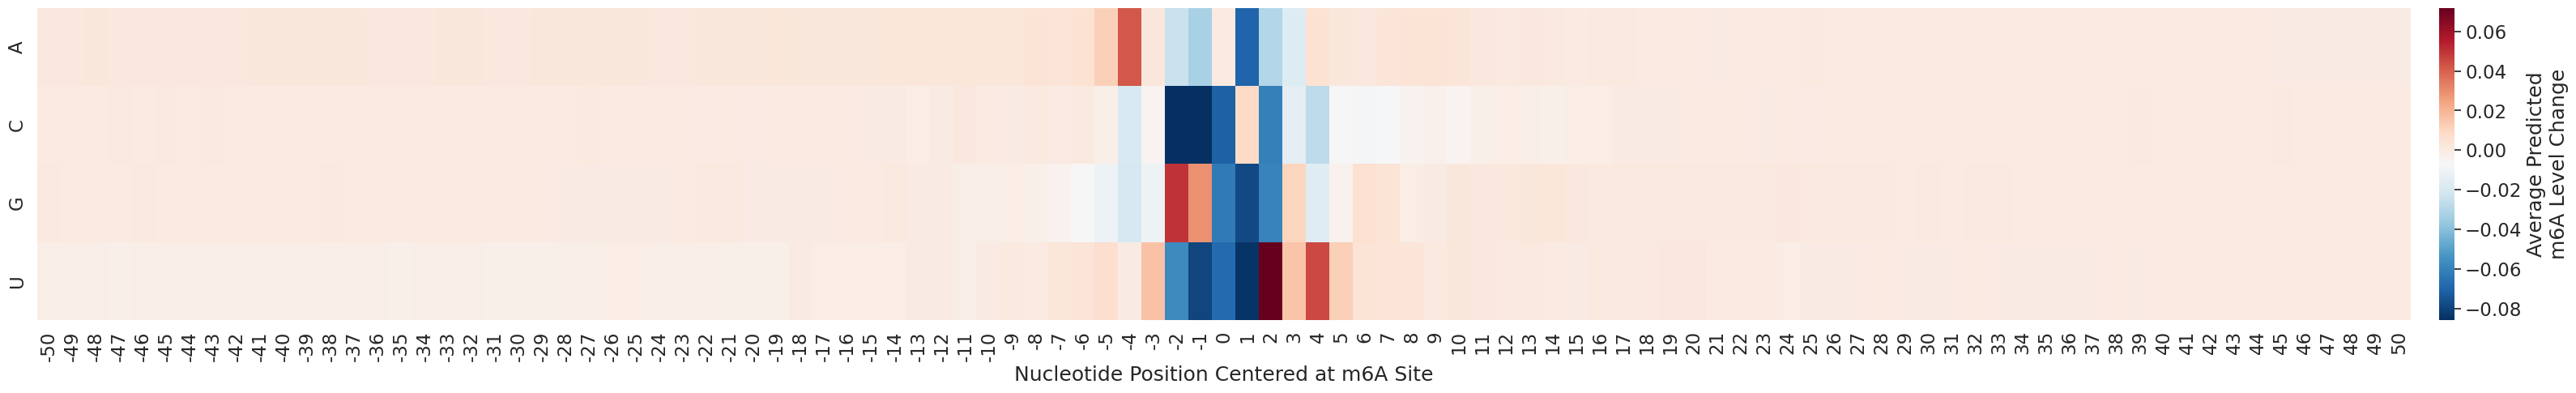

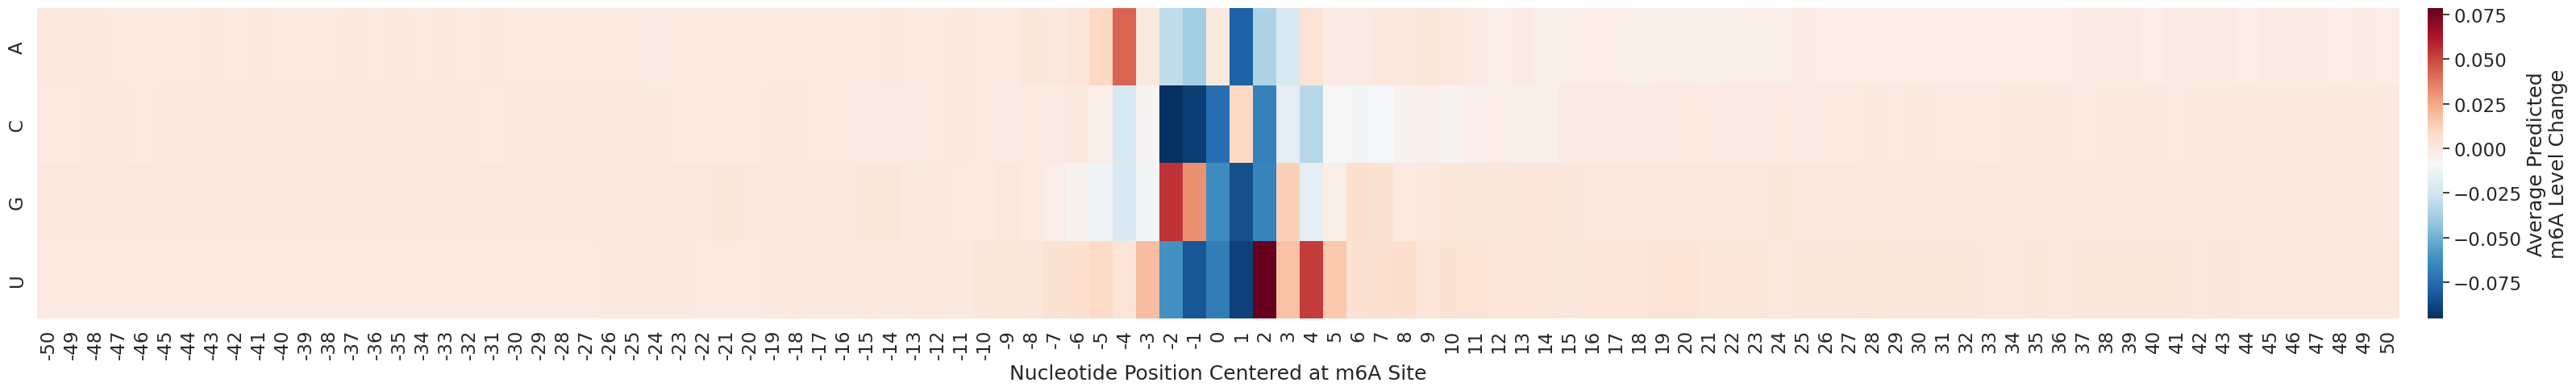

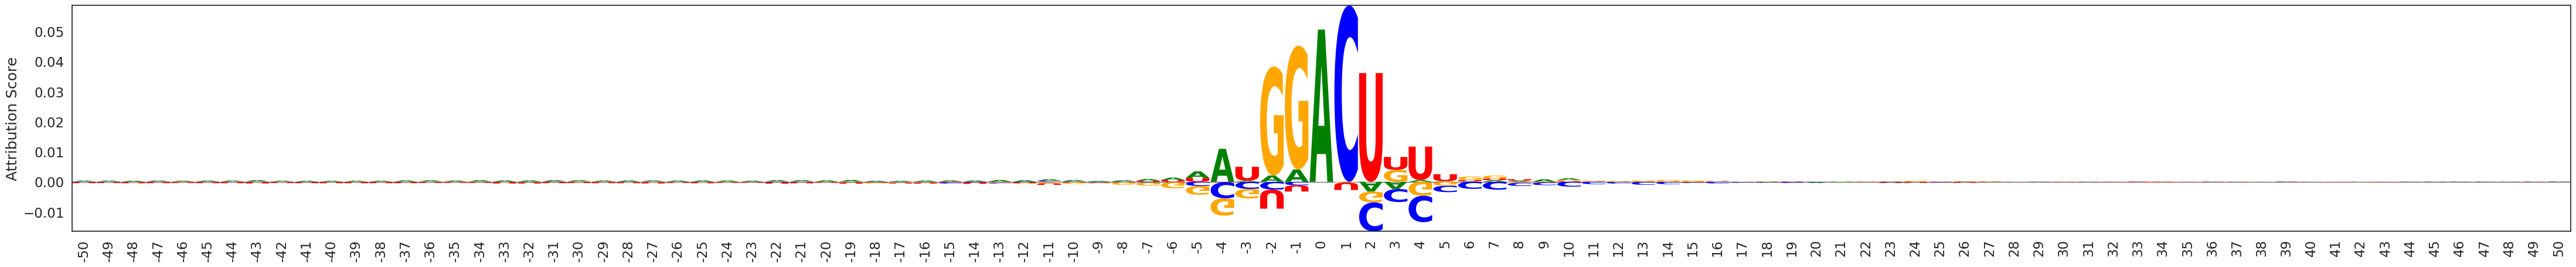

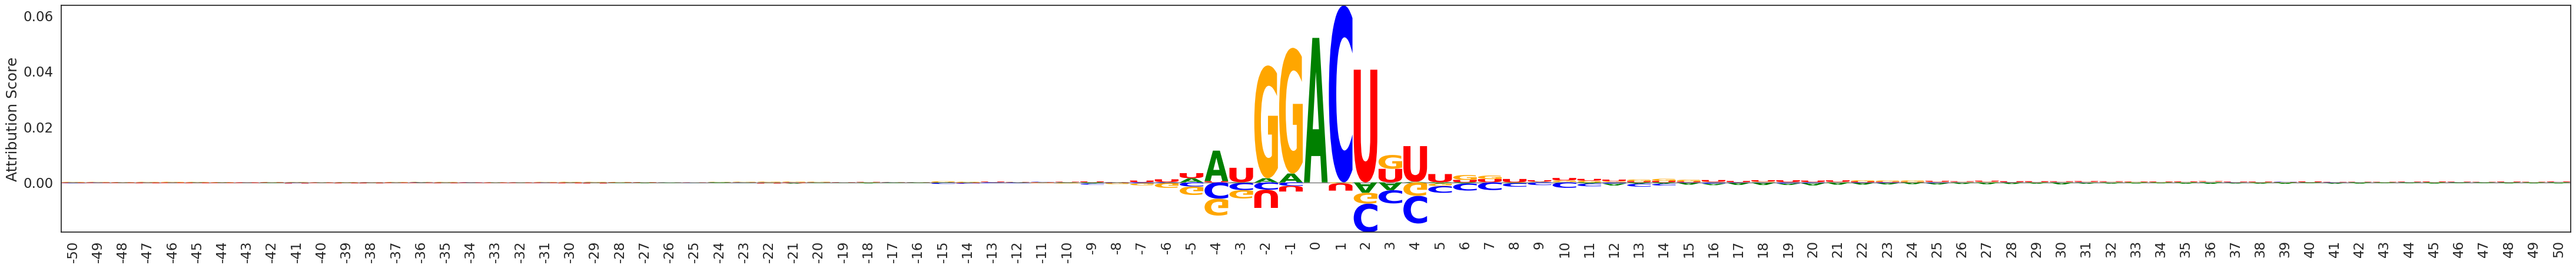

In [369]:
PROJECT_PATH = "/binf-isilon/renniegrp/vpx267/ucph_thesis"
for fold in range(1,2): 
    data = np.load(f"{PROJECT_PATH}/analysis/ism/ism_raw_fold_{fold}_fixed_tune.npz")
    y_delta = data["y_delta"]
    y_ism = data["y_ism"]
    y_ref = data["y_ref"]
    
    seq_fasta_test_path = f"{PROJECT_PATH}/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    valid_data = pd.read_csv(f"{PROJECT_PATH}/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

    valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2

    # Select the top 2000 sequences with lowest average MSE
    selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]
    input_sequences = seq_fasta_one_hot[list(selected_sequences),:,:]

    plot_score_heatmap(torch.Tensor(y_delta), 0, fold, slice_start=450, slice_end=551)
    plot_score_heatmap(torch.Tensor(y_delta), 1, fold, slice_start=450, slice_end=551)
    plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 0,
               fold, slice_start=450, slice_end=551)
    plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 1,
               fold, slice_start=450, slice_end=551)

    

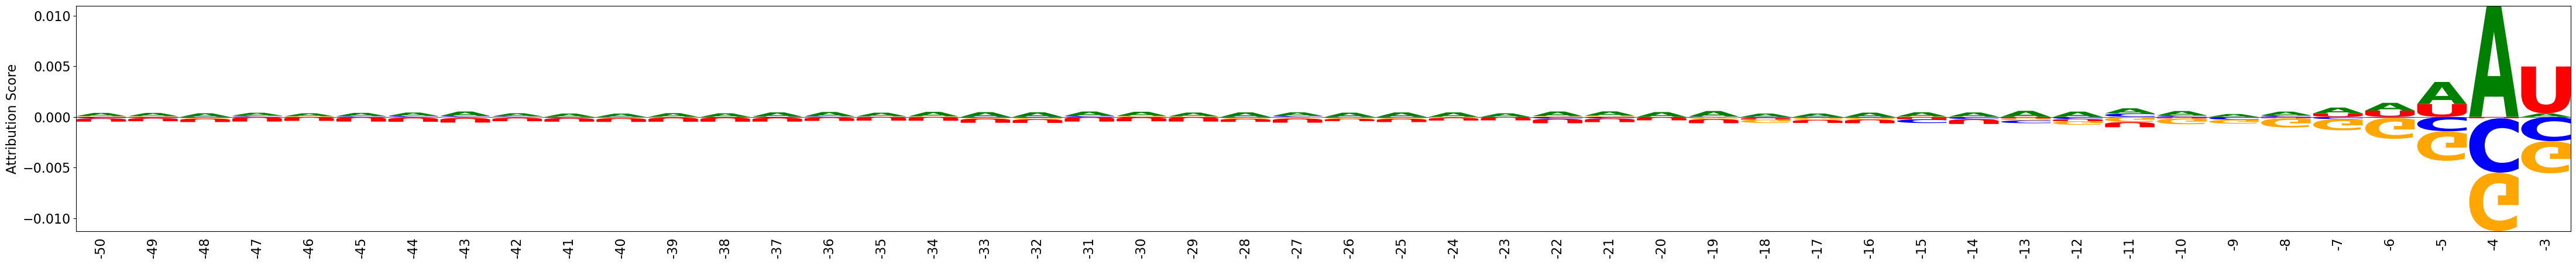

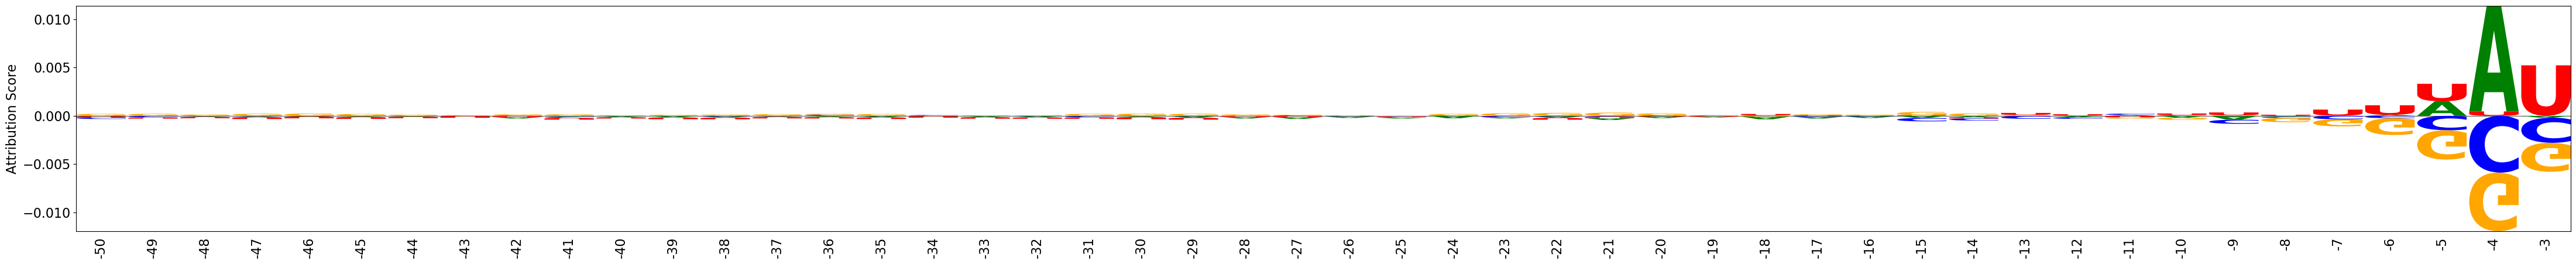

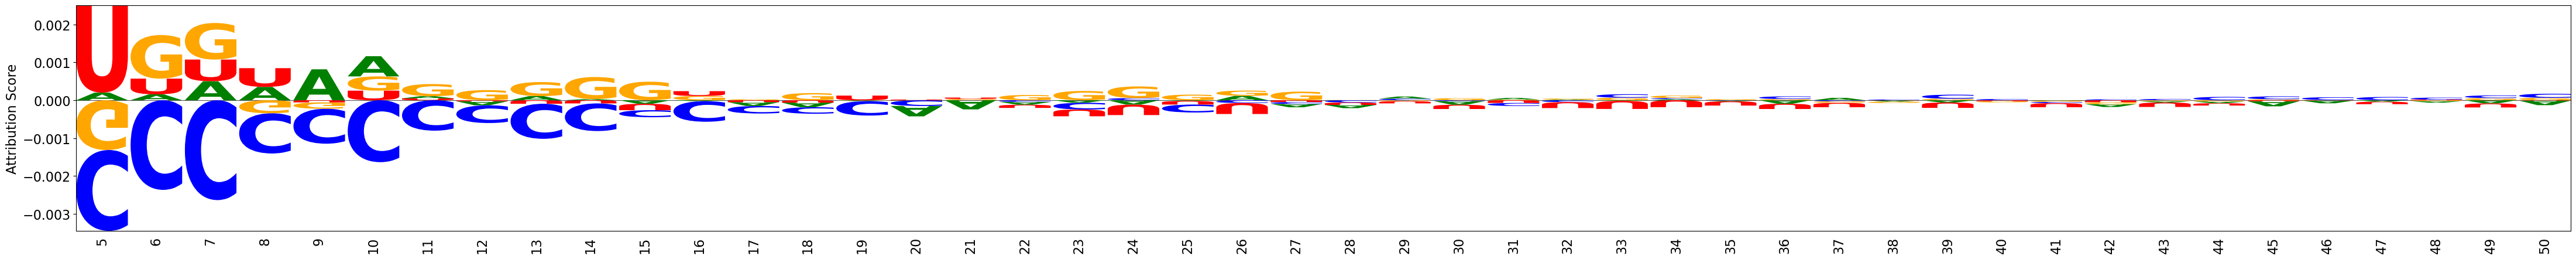

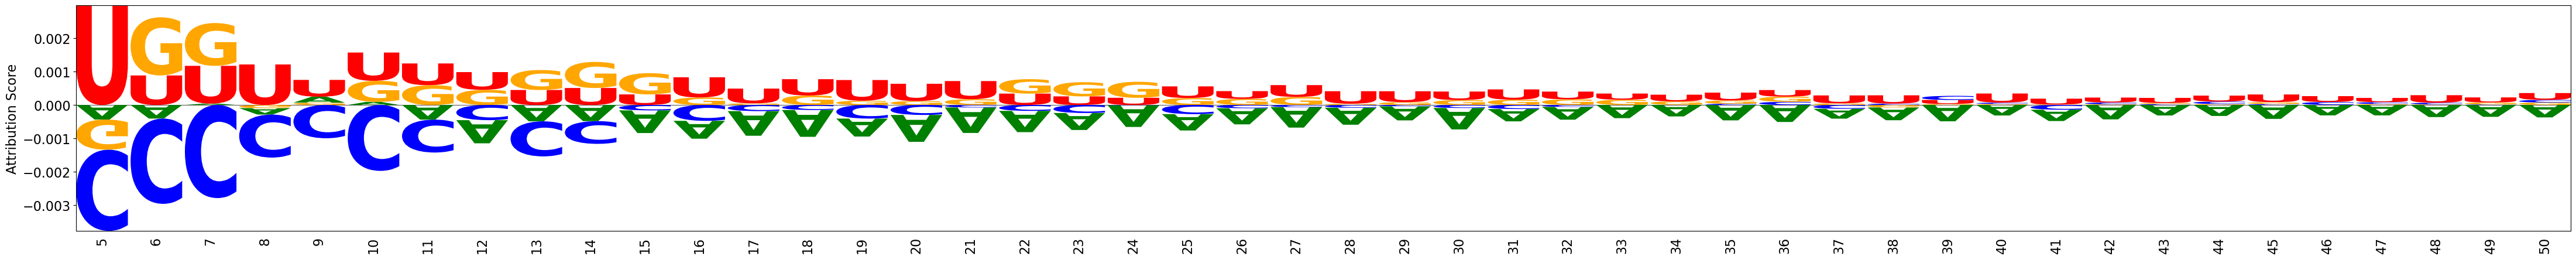

In [ ]:
PROJECT_PATH = "/binf-isilon/renniegrp/vpx267/ucph_thesis"
for fold in range(1,2): 
    data = np.load(f"{PROJECT_PATH}/analysis/ism/ism_raw_fold_{fold}_fixed_tune.npz")
    y_delta = data["y_delta"]
    y_ism = data["y_ism"]
    y_ref = data["y_ref"]
    
    seq_fasta_test_path = f"{PROJECT_PATH}/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    valid_data = pd.read_csv(f"{PROJECT_PATH}/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

    valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2

    # Select the top 2000 sequences with lowest average MSE
    selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]
    input_sequences = seq_fasta_one_hot[list(selected_sequences),:,:]
    plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 0,
               fold, slice_start=450, slice_end=495)
    plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 1,
               fold, slice_start=450, slice_end=495)
    plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 0,
               fold, slice_start=508, slice_end=551)
    plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 1,
               fold, slice_start=508, slice_end=551)

(8000, 101)
(101,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


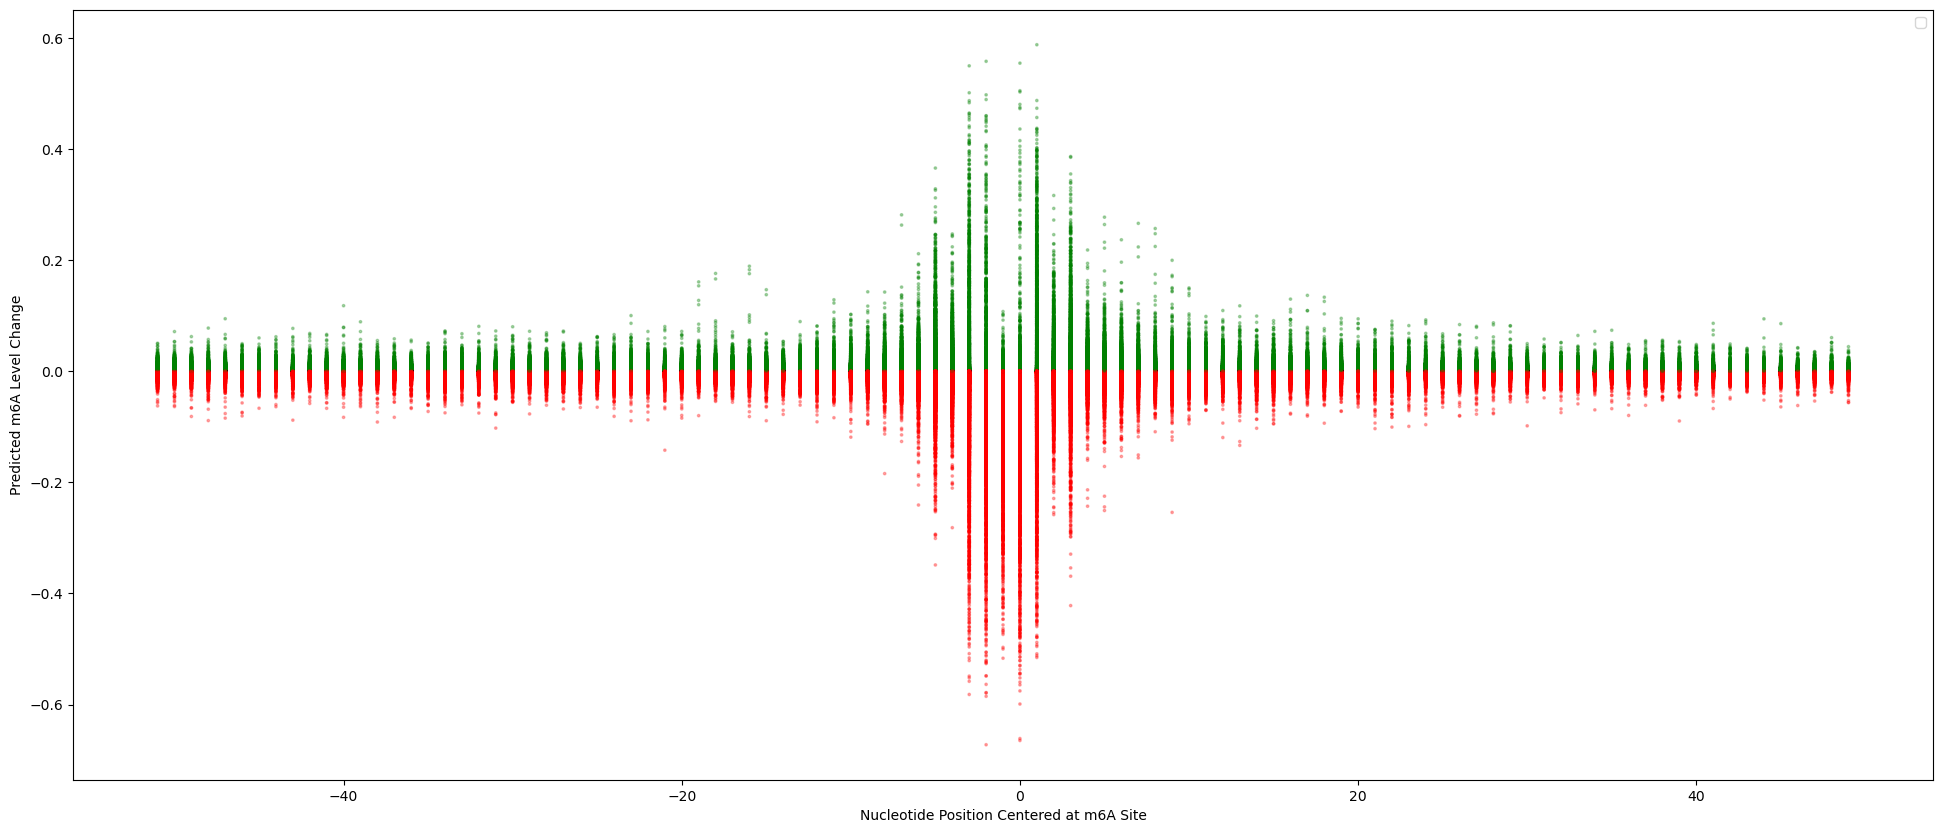

(8000, 101)
(101,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


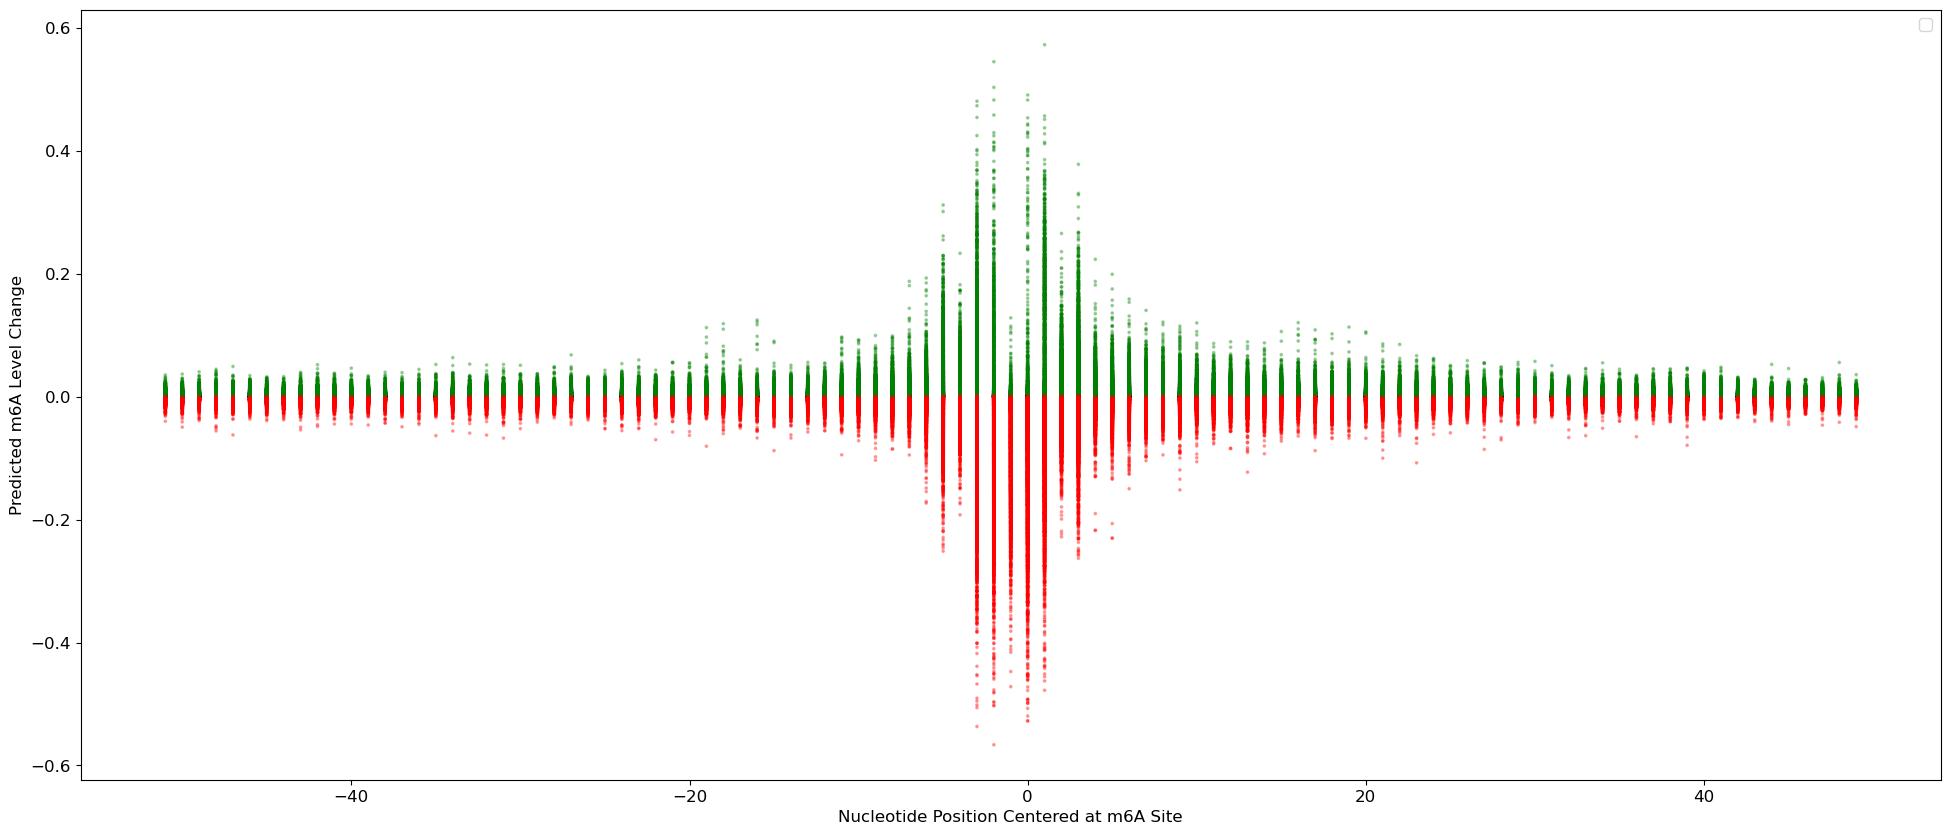

In [4]:
PROJECT_PATH = "/binf-isilon/renniegrp/vpx267/ucph_thesis"
for fold in range(1,2): 
    data = np.load(f"{PROJECT_PATH}/analysis/ism/ism_raw_fold_{fold}_fixed_tune.npz")
    y_delta = data["y_delta"]
    y_ism = data["y_ism"]
    y_ref = data["y_ref"]
    
    seq_fasta_test_path = f"{PROJECT_PATH}/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    valid_data = pd.read_csv(f"{PROJECT_PATH}/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

    valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2

    # Select the top 2000 sequences with lowest average MSE
    selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]
    input_sequences = seq_fasta_one_hot[list(selected_sequences),:,:]

    # plot_score_heatmap(torch.Tensor(y_delta), 0, fold, slice_start=450, slice_end=551)
    # plot_score_heatmap(torch.Tensor(y_delta), 1, fold, slice_start=450, slice_end=551)
    # plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 0,
    #            fold, slice_start=450, slice_end=551)
    # plot_logos(torch.Tensor(y_ref), torch.Tensor(y_ism), input_sequences, 1,
    #            fold, slice_start=450, slice_end=551)

    plot_ism_scatter(torch.Tensor(y_delta), 0, fold, slice_start = 450, slice_end = 551)
    plot_ism_scatter(torch.Tensor(y_delta), 1, fold, slice_start = 450, slice_end = 551)